# **CASTOR $\theta$**

Core collApse Spectral Templates generatOR (CASTOR) is a novel software for data analysis, developed in 2023 by Andrea Simongini, with the supervision of Dr. Fabio Ragosta, Dr. Silvia Piranomonte and Dr. Irene Di Palma. The aim of the software is to build database of synthetic spectra for core collapse supernovae (CCSNe) and to reconstruct the parametric maps for them.

CASTOR collects Photometric (light curves) and Spectrometric (spectra) data for a catalogue of 67 CCSNe. The light curves are taken from Open Supernova Catalog, while the spectra are taken from WISeREP.

The software is divided into four parts: first, preliminary studies detect two important set of parameters, which enable to build synthetic spectra in a consistent way. Then, I apply the spectra reconstruction and the parameter determination on the training set. Lastly, I compare the training set with a new supernova to determine its spectra and parameters.

In [22]:
'''
In this cell I import every external library
I'll use throughout the code
'''

import  numpy as np
import  matplotlib.pyplot as plt
import  pandas as pd
import  math
import  os
import  george
import  warnings
import  openpyxl

import  urllib

import  astropy
import  time

import  random

import  itertools

import  json
import  sys
from    urllib.request  import urlopen

from    astropy.io      import ascii
from    collections     import defaultdict
from    itertools       import chain
from    functools       import partial
from    collections     import Counter
from    numpy           import nanmedian, NaN
from    scipy.optimize  import curve_fit
from    scipy.stats     import chisquare
from    scipy.integrate import trapezoid  as trapz
from    astropy.time    import Time       as TT
from    scipy           import optimize   as op
import  george
from    george.kernels  import Matern32Kernel

In [23]:
'''
In this cell I declare some
functions
'''

def read_csv(path, file_name, sheet, column_name, list_):

  file_location = path + file_name
  table = pd.read_excel(io=file_location, sheet_name=sheet)
  array = []

  if list_ == True:
    for i in range(len(table)):
      array.append(str(table.loc[:,column_name][i]))
  else:
    for i in range(len(table)):
      array = np.array(table.loc[:, column_name].astype(float))

  return array

def get_color_band(band_name):
  color_band = {
      'UVW2': 'purple',
      'UVM2': 'darkviolet',
      'UVW1': 'blueviolet',
      "u'": 'indigo',
      'u': 'royalblue',
      'U': 'dodgerblue',
      'B': 'blue',
      'g': 'limegreen',
      "g'": 'forestgreen',
      'V': 'green',
      'r': 'firebrick',
      "r'": 'darkred',
      'R': 'red',
      'i': 'lightcoral',
      "i'": 'coral',
      'I': 'orange',
      'z': 'darkgoldenrod',
      "z'": 'goldenrod',
      'Y': 'chocolate',
      'J': 'saddlebrown',
      'H': 'darkred',
      'K': 'maroon',
      'Ks': 'darkred',
  }

  if band_name in color_band.keys():
      return color_band[band_name]
  else:
      return 'grey'

def nll(p, y, gp, computed):
  gp.set_parameter_vector(p)
  ll = gp.log_likelihood(y, quiet=True)
  return -ll if np.isfinite(ll) else 1e25


def grad_nll(p, y, gp, computed):
  gp.set_parameter_vector(p)
  return -gp.grad_log_likelihood(y, quiet=True)

def new_mean(array):
  if len(array) >0:
    media = round(np.mean(array))
  else:
    media = 0
  return media

def blackbody(wave, temperature, radius, zeta, distance):

  h          =  planck_ergs      #erg/s
  c          =  light_vel_A      #A/s
  k          =  boltz_ergK       #erg/K

  BB = ( 2 * h * c**2 ) / wave**5 * ( 1 / (np.exp(h * c / (wave * k * temperature)) -1 )) * 10e+16  #erg/s/cm^2/A
  F  = ( zeta * radius / distance ) ** 2 * np.pi * BB
  F  = F * wave                  #erg/s/cm^2

  return F

def exponential(x, a, b, c):

  return a * np.exp(b * x) + c


def linear_fun(x, m, q):
  return m*x + q

def linear_fit(x, y, err):

  par, _ = curve_fit(linear_fun, x, y, sigma=err)
  m = par[0]
  q = par[1]
  return m, q

In [24]:
def sampling_step(x):
  x  = np.sort(x)
  dx = []
  for i in range(len(x) - 1):
    if x[i+1] != x[i]:
      dx.append(x[i+1] - x[i])

  return dx

def magnitude_order(num):
    if num == 0:
        return 0

    absnum = abs(num)
    order = math.log10(absnum)
    res = math.floor(order)

    return res

def avg_distance(x):
  aux = []
  for i in range(len(x)-1):
    aux.append(x[i+1]-x[i])
  return abs(np.mean(aux))

def big_step(x):
  aux = []
  for i in range(len(x)-1):
    aux.append(x[i+1]-x[i])

  big_step = np.max(aux)
  for i in range(len(x)-1):
    if x[i+1] - x[i] == big_step:
      minor = x[i]
      major = x[i+1]

  return minor, major


def time_sorting(array1, array2):

  zip_list   = zip(array1, array2)
  sort_list  = sorted(zip_list, reverse=False)  
  unzip_list = zip(*sort_list)

  new_array1, new_array2 = map(list, unzip_list)

  return np.array(new_array1), np.array(new_array2)


def order_sorting(array1, array2, array3):
  sort_indices = np.argsort(array1)
  new_array1 = array1[sort_indices]
  new_array2 = array2[sort_indices]
  new_array3 = array3[sort_indices]
  return new_array1, new_array2, new_array3

In [25]:
'''
Define the paths.
'''
file_path          = os.path.abspath('Castor.ipynb')
folder_path        = os.path.dirname(file_path)
LOCALPATH          = folder_path + "\\"

excel_path         =  LOCALPATH + "Reference"   + "\\"
results_path       =  LOCALPATH + "Results"     + "\\"
templates_path     =  LOCALPATH + "Templates"   + "\\"
app_path           =  LOCALPATH + "Application" + "\\"
data_path          =  LOCALPATH + "Data"        + "\\"

In [26]:
'''
Define some important parameters:
acceptance : defined to count the spectrometric filter
treshold   : when there's more it's okay
nsteps     : how many steps for MHMC ?
'''

acc           = 0.8  # input("Inserire valore di accettazione (consigliato 0.8): ")
tresh         = 3    # input("Inserire valore di soglia (minimo 3): ")
nsteps        = 5000 # input("Inserire valore di passi (consigliato 5000): ")

In [27]:
'''
Define some important parameters:
acceptance : I count only when there are more than 3 light curves
treshold   : defined to count the spectrometric filter
'''

bandpass               = {}
bandpass['filterlist'] = filterlist = read_csv(excel_path, 'bandpass.xlsx', 'Complete', "Filter",     True)
bandpass['centroid']   = centroid   = read_csv(excel_path, 'bandpass.xlsx', 'Complete', "Wavelength", False)
bandpass['fwhm']       = fwhm       = read_csv(excel_path, 'bandpass.xlsx', 'Complete', "FWHM",       False)
bandpass['corr_mag']   = corr_mag   = read_csv(excel_path, 'bandpass.xlsx', 'Complete', "mAB-mV",     False)

In [28]:
'''
Here I declare some absorption lines common in CCSNe
The letters added to Helium and Iron lines are arbitrarily 
placed in order to distinguish between different wavelengths. 
'''

lines = {'He Ia' : 4471 ,
         'He Ib' : 5876 ,
         'He Ic' : 6678 ,
         'He Id' : 7065 ,
         'He Ie' : 10830,
         'Fe IIa': 4900 ,
         'Fe IIb': 5500 ,
         'Fe IIc': 5300 ,
         '[Fe II]': 7155,
         'Ha'    : 6563 ,
         'Hb'    : 4861 ,
         'Hg'    : 4341 ,
         'Hd'    : 4102 ,
         '[Si II]': 6150}

In [29]:
'''
Here I define some constants
'''

light_vel_A = 3e+18         #A/s
light_vel_km= 3e+5          #km/s
planck_ergs = 6.63e-27      #erg/s
boltz_ergK  = 1.38e-16      #erg/K
boltz_eVK   = 8.61327e-5    #eV/K
R_sun_mpc   = 2.25e-14      #Mpc
R_sun_cm    = 6.960e+10     #cm
R_sun_km    = 6.960e+5      #km

Hubble_70   = 70            #km/s/Mpc

M_sun_g     = 1.98892e+33   #g

L_sun_ergs  = 3.832e+33

# Section 0: data extraction and results saving


In [30]:
SN_names      = read_csv(excel_path, 'SN_names.xlsx', 'SN_names',"Name",True)

In [31]:
class data_extraction:

  def __init__(self, name, path, acc, tresh, bandpass):

    self.name       = name
    self.path       = path
    self.acc        = acc
    self.tresh      = tresh
    self.filterlist = bandpass['filterlist']
    self.centroid   = bandpass['centroid']
    self.fwhm       = bandpass['fwhm']


  def collect_lightcurves(self):
    
    lc_path     = self.path + 'data_lightcurves' + "\\" + self.name + ".dat"
    lc_set      = defaultdict(int)
    time_array  = ([])
    mag_array   = ([])
    emag_array  = ([])
    band_list   = []

    with open(lc_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            time = float(parts[0])
            mag  = float(parts[1])
            emag = float(parts[2])
            band = parts[3]

            time_array = np.append(time_array, time)
            mag_array  = np.append(mag_array, mag)
            emag_array = np.append(emag_array, emag)
            band_list.append(band)

    lc_filters = [band_list[0]]
    for i in range(len(band_list)-1):
      if band_list[i] != band_list[i+1]:
        lc_filters.append(band_list[i+1])

    for filtro in lc_filters:
      lc_set['time_%s'%filtro]  = [time_array[index]   for index, val in enumerate(band_list) if val == filtro]
      lc_set['mag_%s' %filtro]  = [mag_array[index]    for index, val in enumerate(band_list) if val == filtro]
      lc_set['emag_%s'%filtro]  = [emag_array[index]   for index, val in enumerate(band_list) if val == filtro]

    return lc_filters, lc_set


  def collect_spectra(self):
    
    sp_set        = defaultdict(int)
    spectra_path  = self.path + 'data_spectra' + "\\" + self.name + "\\"
    all_files     = os.listdir(spectra_path)
    valid_files   = [file for file in all_files if not (file.startswith('.') or file.lower() == 'desktop.ini')]
    all_epochs    = ([])


    for single_file in valid_files:
      file_name    = single_file.split('_')[1]
      epoch        = file_name.rsplit('.', 1)[0]

      all_epochs  = np.append(all_epochs, float(epoch))
      data        = ascii.read(spectra_path + single_file)
      sp_set['wave_%s'%str(epoch)]  = data[0][:]
      sp_set['ewave_%s'%str(epoch)] = data[1][:]
      sp_set['flux_%s'%str(epoch)]  = data[2][:]
      sp_set['eflux_%s'%str(epoch)] = data[3][:]

    return all_epochs, sp_set


  def spectral_bands(self, sp_set, files):
    
    sp_filters = {}

    for epoch in files:

      sp_filters['filt_%s'%str(epoch)] = []
      wave    = np.array(sp_set['wave_' + str(epoch)])
      
      for filtro in self.filterlist:

        min_wave  = [self.centroid[i]-self.fwhm[i]/2   for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
        max_wave  = [self.centroid[i]+self.fwhm[i]/2   for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
        ff        = [self.fwhm[i]                      for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]

        mini      = min_wave[0] + ff[0] * self.acc
        maxi      = max_wave[0] - ff[0] * self.acc

        mask  = [val for val in wave if min_wave[0] <= val <= mini]
        mask1 = [val for val in wave if maxi <= val <= max_wave[0]]

        if mask and mask1:
          sp_filters['filt_%s'%str(epoch)].append(filtro)

    return sp_filters


  def matched_bands(self, lc_filters, sp_filters):

    total_filters = sum(sp_filters.values(), [] )

    return sorted(set(lc_filters).intersection(total_filters))


  def total_exploration(self):
    
    lc_filters, lc_set  = self.collect_lightcurves()
    files, sp_set       = self.collect_spectra()
    sp_filters          = self.spectral_bands(sp_set, files)
    matched             = self.matched_bands(lc_filters, sp_filters)

    return (files, sp_set, lc_filters, lc_set, sp_filters, matched)

In [32]:
class templates_extraction:

  def __init__(self, name, path, acc, tresh, bandpass):

    self.name       = name
    self.path       = path
    self.acc        = acc
    self.tresh      = tresh
    self.filterlist = bandpass['filterlist']
    self.centroid   = bandpass['centroid']
    self.fwhm       = bandpass['fwhm']


  def read_templates(self):

    temp_set      = defaultdict(int)
    spectra_path  = self.path + 'Templates' + "\\"
    all_files     = os.listdir(spectra_path)
    valid_files   = [file for file in all_files if not (file.startswith('.') or file.lower() == 'desktop.ini')]
    all_epochs    = ([])

    for single_file in valid_files:
      file_name    = single_file.split('_')[1]
      epoch        = float(file_name.rsplit('.', 1)[0])
      all_epochs   = np.append(all_epochs, float(epoch))
      data         = ascii.read(spectra_path + single_file)

      temp_set['wave_%s'%str(epoch)]  = np.array(data[0][:])
      temp_set['flux_%s'%str(epoch)]  = np.array(data[1][:])
      temp_set['eflux_%s'%str(epoch)] = np.array(data[2][:])

    return all_epochs, temp_set


  def temp_filters(self, all_epochs, temp_set):
    
    sp_filters = defaultdict(int)

    for epoch in all_epochs:

      sp_filters['filt_%s'%str(epoch)] = []
      wave    = np.array(temp_set['wave_' + str(epoch)])

      for filtro in self.filterlist:

        min_wave  = [self.centroid[i]-self.fwhm[i]/2   for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
        max_wave  = [self.centroid[i]+self.fwhm[i]/2   for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
        ff        = [self.fwhm[i]                      for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]

        mini      = min_wave[0] + ff[0] * self.acc
        maxi      = max_wave[0] - ff[0] * self.acc

        mask  = [val for val in wave if min_wave[0] <= val <= mini]
        mask1 = [val for val in wave if maxi <= val <= max_wave[0]]

        if mask and mask1:
          sp_filters['filt_%s'%str(epoch)].append(filtro)

    return sp_filters


  def use_templates(self):

    files, temp_set = self.read_templates()
    sp_filters      = self.temp_filters(files, temp_set)

    return files, temp_set, sp_filters

# Section 1: preliminary studies

In [33]:
class calibration():

  def __init__(self, name, files, sp_set, lc_filters, lc_set, matched, bandpass):

    self.name         = name
    self.files        = files
    self.sp_set       = sp_set
    self.lc_filters   = lc_filters
    self.lc_set       = lc_set
    self.matched      = matched
    self.filterlist   = bandpass['filterlist']
    self.centroid     = bandpass['centroid']
    self.fwhm         = bandpass['fwhm']
    self.corr_mag     = bandpass['corr_mag']

  def gaussian_process(self):
    
    gp_set = defaultdict(int)
    for filtro in self.lc_filters:
      x           = np.array(self.lc_set['time_' + filtro])
      y           = np.array(self.lc_set['mag_'  + filtro])
      yerr        = np.array(self.lc_set['emag_' + filtro])
      amplitude   = np.mean(y)

      lengthscale0 = np.mean(x)
      lengthscale1 = np.min(sampling_step(x))
      lengthscale2 = np.max(sampling_step(x))

      k0           = amplitude * Matern32Kernel(lengthscale0)
      k1           = amplitude * Matern32Kernel(lengthscale1)
      k2           = amplitude * Matern32Kernel(lengthscale2)

      kernel       = k1 + k2 + k0

      gp          = george.GP(kernel)
      star        = gp.compute(x, yerr)

      p0          = gp.get_parameter_vector()
      results     = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
      gp.set_parameter_vector(results.x)

      t           = np.linspace(np.min(x), np.max(x), 5000)
      mu, cov     = gp.predict(y, t)
      std         = np.sqrt(cov.diagonal())

      gp_set['t_%s'%filtro]    = t
      gp_set['mu_%s'%filtro]   = mu
      gp_set['std_%s'%filtro]  = std

    return gp_set

  def mangling(self, gp_set, cheat = True):
    
    SP        = ([])
    LC        = ([])
    ERR       = ([])

    for epoch in self.files:

      wave    = np.array(self.sp_set['wave_' + str(epoch)])
      flux    = np.array(self.sp_set['flux_' + str(epoch)])
      f_nu    = flux * wave**2/ light_vel_A

      for filtro in self.matched:
        t           = np.array(gp_set['t_'    + filtro])
        mu          = np.array(gp_set['mu_'   + filtro])
        std         = np.array(gp_set['std_'  + filtro])

        closest = min(t, key = lambda x: abs(x-epoch))
        mg_lc   = [mu[i]  for i in range(0, len(mu))   if t[i] == closest]
        err_lc  = [std[i] for i in range(0, len(std))  if t[i] == closest]

        mg_lc   = mg_lc[0]
        err_lc  = err_lc[0]

        mean_flux = np.mean(f_nu)

        if mean_flux < 0 :
          mean_flux = -np.inf

        mg_sp = -2.5*np.log10(mean_flux) - 48.6

        cor_mag = [self.corr_mag[i] for i in range(len(self.corr_mag)) if filtro == self.filterlist[i]]
        if math.isnan(cor_mag[0]) == False:
          mg_sp = mg_sp - cor_mag[0]

        if math.isfinite(mg_sp):
          SP  = np.append(SP, mg_sp)
          LC  = np.append(LC, mg_lc)
          ERR = np.append(ERR, err_lc)

        if cheat == True:
          save_sp   = np.array([])
          save_lc   = np.array([])
          save_err  = np.array([])
          for i in range(len(ERR)):
            if ERR[i] < 10*np.mean(ERR):
              if abs(SP[i]-LC[i]) < 2:
                save_sp   = np.append(save_sp, SP[i])
                save_lc   = np.append(save_lc, LC[i])
                save_err  = np.append(save_err, ERR[i])
          SP  = save_sp
          LC  = save_lc
          ERR = save_err

    return  SP, LC, ERR


  def remangling(self, gp_set, SP, LC, ERR, cheat = True ):

    m0, q0 = linear_fit(SP, LC, ERR)

    for epoch in self.files:
      wave    = np.array(self.sp_set['wave_' + str(epoch)])
      flux    = np.array(self.sp_set['flux_' + str(epoch)])
      extraSP = ([])
      extraLC = ([])
      extraER = ([])

      out_filters = list(set(self.lc_filters) - set(self.matched))

      for filtro in out_filters:
        t           = np.array(gp_set['t_'    + filtro])
        mu          = np.array(gp_set['mu_'   + filtro])
        std         = np.array(gp_set['std_'  + filtro])

        closest     = min(t, key = lambda x: abs(x-epoch))
        mg_lc       = [mu[i]  for i in range(0, len(mu)) if t[i] == closest]
        mg_lc       = mg_lc[0]

        eff_wav     = [self.centroid[i] for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
        cor_mag     = [self.corr_mag[i] for i in range(len(self.corr_mag))    if self.filterlist[i] == filtro]

        if math.isnan(cor_mag[0]) == False: cor_mag = cor_mag[0]
        else: cor_mag = 0

        mg_sp       = (mg_lc - q0) / m0
        new_flux    = light_vel_A * 10**(- 0.4* (mg_sp + 48.6 - cor_mag)) / eff_wav[0]**2
        flux        = np.append(flux, new_flux)
        wave        = np.append(wave, eff_wav[0])
        wave, flux  = time_sorting(wave, flux)

      f_nu = flux * wave**2 / light_vel_A

      for filtro in out_filters:

        t           = np.array(gp_set['t_'    + filtro])
        mu          = np.array(gp_set['mu_'   + filtro])
        std         = np.array(gp_set['std_'  + filtro])

        closest = min(t, key = lambda x: abs(x-epoch))
        mg_lc   = [mu[i]  for i in range(0, len(mu))   if t[i] == closest]
        err_lc  = [std[i] for i in range(0, len(std))  if t[i] == closest]
        mg_lc   = mg_lc[0]
        err_lc  = err_lc[0]

        min_wave = [self.centroid[i]-self.fwhm[i]/2   for i in range(0, len(self.filterlist))  if self.filterlist[i] == filtro]
        max_wave = [self.centroid[i]+self.fwhm[i]/2   for i in range(0, len(self.filterlist))  if self.filterlist[i] == filtro]
        ff       = [self.fwhm[i]                      for i in range(0, len(self.filterlist))  if self.filterlist[i] == filtro]
        ff       = ff[0]

        in_band_flux = []
        for i in range(len(wave)):
          if wave[i] >= min_wave and wave[i] <= max_wave:
            in_band_flux.append(f_nu[i])

        if in_band_flux:

          mean_flux = np.mean(in_band_flux)
          if mean_flux < 0 : mean_flux = -np.inf
          mg_sp = -2.5*np.log10(mean_flux) - 48.6

          cor_mag = [self.corr_mag[i] for i in range(len(self.corr_mag)) if filtro == self.filterlist[i]]
          if math.isnan(cor_mag[0]) == False:
            mg_sp = mg_sp - cor_mag[0]
          if math.isfinite(mg_sp):
            extraSP   = np.append(extraSP, mg_sp)
            extraLC   = np.append(extraLC, mg_lc)
            extraER   = np.append(extraER, err_lc)

          if cheat == True:
            save_sp   = np.array([])
            save_lc   = np.array([])
            save_err  = np.array([])
            for i in range(len(extraER)):
              if extraER[i] < 10*np.mean(ERR):
                if abs(extraSP[i]-extraLC[i]) < 2:
                  save_sp   = np.append(save_sp, extraSP[i])
                  save_lc   = np.append(save_lc, extraLC[i])
                  save_err  = np.append(save_err, extraER[i])
            extraSP  = save_sp
            extraLC  = save_lc
            extraER = save_err

    return extraSP, extraLC, extraER


  def calibration(self, SP, LC, ER, extraSP, extraLC, extraER):

    tot_SP  = np.append(SP, extraSP)
    tot_LC  = np.append(LC, extraLC)
    tot_ER  = np.append(ER, extraER)
    m0, q0  = linear_fit(tot_SP, tot_LC, tot_ER)
    uncal_SP= (tot_LC - q0) / m0
    m1, q1  = linear_fit(uncal_SP, tot_LC, tot_ER)
    cal_SP  = (uncal_SP * m1 ) + q1

    return cal_SP, uncal_SP, tot_LC, tot_ER


  # def run_calibration(self, cheat = True):

  #   gp_set                            = self.gaussian_process()
  #   SP, LC, ER                        = self.mangling(gp_set, cheat = cheat)
  #   extraSP, extraLC, extraER         = self.remangling(gp_set, SP, LC, ER, cheat = cheat)
  #   cal_SP, uncal_SP, tot_LC, tot_ER  = self.calibration(SP, LC, ER, extraSP, extraLC, extraER)


  def counting_filters(self, lc_counter, sp_counter, total_counter):

    ordered_filters = [
        'UVW2', 'UVM2', 'UVW1', "u'", 'u', 'U', "U'", 'C', 'v', 'B', "B'", 'b', 'g', "g'", 'V', 'y',
        "v'", 'G', "V'", 'r', "r'", 'R', 'Rc', 'i', "i'", 'I', 'z', 'Ic', "z'", 'Z', 'Y', 'J', 'H',
        'K', 'Ks', 'I1', 'I2'
    ]

    lcc       = Counter(list(chain(*lc_counter)))
    spc       = Counter(list(chain(*sp_counter)))
    ttc       = Counter(list(chain(*total_counter)))
    sorted_lcc = {key: lcc[key] for key in ordered_filters if key in lcc}
    sorted_spc = {key: spc[key] for key in ordered_filters if key in spc}
    sorted_ttc = {key: ttc[key] for key in ordered_filters if key in ttc}


    return sorted_lcc, sorted_spc, sorted_ttc


  def define_the_bandwidth(self, lc_counter, sp_counter, total_counter):

    _, _, sorted_ttc  =  self.counting_filters(lc_counter, sp_counter, total_counter)

    wavs = []

    for key, value in sorted_ttc.items():
        if value > 10 and key in self.filterlist:
            idx = filterlist.index(key)
            wavs.append(self.centroid[idx] - self.fwhm[idx] / 2)

    min_w = min(wavs)
    max_w = max(wavs)

    return min_w, max_w


  def plot_histogram(self, lc_counter, sp_counter, total_counter):

    sorted_lcc, sorted_spc, sorted_ttc = self.counting_filters(lc_counter, sp_counter, total_counter)

    df1 = pd.DataFrame(list(sorted_lcc.items()), columns=['Value', 'Count'])
    df2 = pd.DataFrame(list(sorted_spc.items()), columns=['Value', 'Count'])
    df3 = pd.DataFrame(list(sorted_ttc.items()), columns=['Value', 'Count'])
    df1 = df1.set_index('Value')
    df2 = df2.set_index('Value')
    df3 = df3.set_index('Value')

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 11), sharex=True)


    dataframes = [df1, df2, df3]

    for i, ax in enumerate(axes):
        ax.grid()
        sub_df = dataframes[i]
        band_colors = [get_color_band(band_name) for band_name in sub_df.index]
        ax.bar(sub_df.index, sub_df['Count'], color=band_colors)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        for tick in ax.get_yticklabels():
          tick.set_fontweight('bold')

        if i < 2:
            ax.set_xticks([])


    axes[2].set_xticks(df3.index)
    for tick in axes[2].get_xticklabels():
        tick.set_fontweight('bold')

    axes[0].text(0.99, 0.97, 'Light Curves', transform=axes[0].transAxes, ha='right', va='top', fontsize=25, fontweight='bold')
    axes[1].text(0.99, 0.97, 'Spectra', transform=axes[1].transAxes, ha='right', va='top', fontsize=25, fontweight='bold')
    axes[2].text(0.99, 0.97, 'Matched', transform=axes[2].transAxes, ha='right', va='top', fontsize=25, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [1]:
'''
Here I apply the study on filters.

if execute == True I run the code on every supernova
if execute == False I define immediatly the confident value

Until the case-of-study catalogue is not modified,
mantain execute = False: the results are already given

'''

execute = False
lc_counter, sp_counter, total_counter      =  [],   [],   []
aux1, aux2, aux3                           = ([]), ([]), ([])

if execute:

  for name in SN_names:
    de_class = data_extraction(name, data_path, acc, tresh, bandpass)
    files, sp_set, lc_filters, lc_set, sp_filters, matched  = de_class.total_exploration()

    lc_counter.append(lc_filters)
    sp_counter.append(sum(sp_filters.values(), [] ))
    total_counter.append(matched)

  cal           = calibration(name, files, sp_set, lc_filters, lc_set, matched, bandpass)

  min_w, max_w  = cal.define_the_bandwidth(lc_counter, sp_counter, total_counter)

  cal.plot_histogram(lc_counter, sp_counter, total_counter)

else:

  min_w = 3000
  max_w = 9000

In [ ]:
'''
Here I calibrate light curves and spectra to obtain a
set of calibration parameters: mean_m and mean_q

if execute == True I run the code on every supernova
if execute == False I define the parameters by past results

Until the case-of-study catalogue is not modified,
mantain execute = False: the results are already given
'''

execute = False
tocheat = False
if execute:

  mean_m, mean_q = ([]) , ([])
  SP, LC, ER     = ([]), ([]), ([])

  for name in SN_names:
      de_class    = data_extraction(name, data_path, acc, tresh, bandpass)
      files, sp_set, lc_filters, lc_set, _ , matched  = de_class.total_exploration()
      cal         = calibration(name, files, sp_set, lc_filters, lc_set, matched, bandpass)
      gp_set      = cal.gaussian_process()
      x, y, yerr  = cal.mangling(gp_set, cheat = tocheat)
      m0, q0      = linear_fit(x, y, yerr)

      SP = np.append(SP, x)
      LC = np.append(LC, y)
      ER = np.append(ER, yerr)

      mean_m, mean_q = linear_fit(SP, LC, ER)
      plt.plot(SP, LC, '.', color='cyan')
      plt.plot(SP, linear_fun(SP, mean_m, mean_q), '-', color='red')

else:
  mean_m, mean_q = 0.892407, 0.891162

print('Si ha m = %f'%mean_m, 'e q = %f'%mean_q)

In [ ]:
# SP = abs(SP)

# x = ([])
# y = ([])
# yerr = ([])

# for i in range(len(LC)):
#   if ER[i]<1:
#       x    = np.append(x, SP[i])
#       y    = np.append(y, LC[i])
#       yerr = np.append(yerr, ER[i])


# for i in range(len(x)):
#   if x[i]>30:
#     yerr[i] = yerr[i] * 30
#   if x[i] >25 and x[i]<30:
#     yerr[i] = yerr[i] * 15
#   if x[i] <5 and y[i]>15:
#     yerr[i] = yerr[i] * 15


# plt.figure(figsize=(13, 7))
# plt.errorbar(x, y, yerr, fmt='.', color='blue', label='Global data', zorder=2)
# plt.plot(x, linear_fun(x, mean_m, mean_q), '-', color='orange', label='Linear fit', zorder=3)
# plt.grid(zorder=1)  # Imposta lo zorder della griglia sopra gli altri elementi
# plt.legend(loc='best', ncol=1, fontsize=15)
# plt.xlabel('Spectrometric magnitude', fontsize=15, fontweight='bold')
# plt.ylabel('Photometric magnitude', fontsize=15, fontweight='bold')
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(reversed(handles), reversed(labels), loc='upper left', ncol=1, fontsize=16)


# Section 2: chi-squared test comparison

I'm testing the capabilities of CASTOR on a new supernova, outside the catalogue of study. Right now, I'm focusing on SN2015ap.


If you want to study a different supernova, you need to add your data in the directory specified by "new_path". This file has to be in .dat format, with three columns: epoch, magnitude, error and filter.

In [16]:
new_name              = 'SN2015ap'
new_path              = LOCALPATH + 'Application' + "\\" + new_name + "\\"

In [17]:
def read_lightcurves(name, path):

  name_file = path + name + ".dat"
  lc_set   = defaultdict(int)
  time_array  = ([])
  mag_array   = ([])
  emag_array  = ([])
  band_list   = []

  with open(name_file, 'r') as file:
      for line in file:
          parts = line.strip().split()
          time = float(parts[0])
          mag  = float(parts[1])
          emag = float(parts[2])
          band = parts[3]

          time_array = np.append(time_array, time)
          mag_array  = np.append(mag_array, mag)
          emag_array = np.append(emag_array, emag)
          band_list.append(band)

  lc_filters = [band_list[0]]
  for i in range(len(band_list)-1):
    if band_list[i] != band_list[i+1]:
      lc_filters.append(band_list[i+1])

  for filtro in lc_filters:
    lc_set['time_%s'%filtro]  = [time_array[index]   for index, val in enumerate(band_list) if val == filtro]
    lc_set['mag_%s' %filtro]  = [mag_array[index]    for index, val in enumerate(band_list) if val == filtro]
    lc_set['emag_%s'%filtro]  = [emag_array[index]   for index, val in enumerate(band_list) if val == filtro]

  return lc_filters, lc_set

def toe(lc_set, lc_filters):

  t0, t1, dt = ([]), ([]), ([])

  for filtro in lc_filters:
    time = np.array(lc_set['time_' + filtro])
    t1   = np.append(t1, time[0])
    dt   = np.append(dt, avg_distance(time[0:10]))
    t0   = np.append(t0, t1-dt)

  min_value = np.min(t0)
  std_value = np.std(t0)

  return min_value

def rescale_time(lc_filters, lc_set, t0):

  new_set = {}

  for filtro in lc_filters:
    time                      = np.array(lc_set['time_' + filtro])
    mag                       = np.array(lc_set['mag_' + filtro])
    emag                      = np.array(lc_set['emag_' + filtro])
    scale_time                = time - t0
    scale_time, mag, emag     = order_sorting(scale_time, mag, emag)
    new_set['time_%s'%filtro] = scale_time
    new_set['mag_%s'%filtro]  = mag
    new_set['emag_%s'%filtro] = emag

  return new_set


def gaussian_process(common_filters, lc_set_obs, lc_set_new):

  gp_set = defaultdict(int)
  for filtro in common_filters:

    ref_time    = np.array(lc_set_new['time_' + filtro])

    x           = np.array(lc_set_obs['time_' + filtro])
    y           = np.array(lc_set_obs['mag_'  + filtro])
    yerr        = np.array(lc_set_obs['emag_' + filtro])
    amplitude   = np.mean(y)

    lengthscale0 = np.mean(x)
    lengthscale1 = np.min(sampling_step(x))
    lengthscale2 = np.max(sampling_step(x))

    k0           = amplitude * Matern32Kernel(lengthscale0)
    k1           = amplitude * Matern32Kernel(lengthscale1)
    k2           = amplitude * Matern32Kernel(lengthscale2)

    kernel       = k1 + k2 + k0

    gp           = george.GP(kernel)
    star         = gp.compute(x, yerr)

    p0           = gp.get_parameter_vector()
    results      = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
    gp.set_parameter_vector(results.x)

    mu, cov      = gp.predict(y, ref_time)
    std          = np.sqrt(cov.diagonal())

    gp_set['time_%s'%filtro]    = ref_time
    gp_set['mag_%s'%filtro]     = mu
    gp_set['std_%s'%filtro]     = std

  return gp_set


def comparison(name_obs, name_new, path_obs, path_new):

  obs_filters, obs_set = read_lightcurves(name_obs, path_obs)
  new_filters, new_set = read_lightcurves(name_new, path_new)

  common_filters = set(obs_filters) & set(new_filters)

  t0_obs = toe(obs_set, obs_filters)
  t0_new = toe(new_set, new_filters)

  obs_set = rescale_time(obs_filters, obs_set, t0_obs)
  new_set = rescale_time(new_filters, new_set, t0_new)

  gp_set  = gaussian_process(common_filters, obs_set, new_set)

  chi2_total_norm = ([])
  len_filters     = ([])
  chi2_total      = ([])

  for filtro in common_filters:
      mag1  = gp_set['mag_' + filtro]
      mag2  = np.array(new_set['mag_' + filtro])
      mag2  = np.sum(mag1)/np.sum(mag2) * mag2

      chi2_single, _   = chisquare(f_obs=mag1, f_exp=mag2)
      chi2_total_norm  = np.append(chi2_total_norm, chi2_single/len(mag2))
      chi2_total       = np.append(chi2_total, chi2_single)


  total_chi2          = np.sum(chi2_total_norm)
  total_chi2_norm     = total_chi2 / len(common_filters)
  len_filters         = np.append(len_filters, len(common_filters))

  print(name_obs,'\t', 'chi2 total: ', total_chi2, '\t', 'chi2 normalizzato:', total_chi2_norm,'\t',  'len filters: ', len_filters)

  return (total_chi2_norm, len_filters)


In [18]:
'''
Here I compare the new supernova
with every supernova in the case-of-study (COS) catalogue

Until the case-of-study catalogue doesn't change (or I don't add new data)
the best match for SN2015ap is iPTF13bvn
'''

execute = False

if execute:

  new_filters, new_set  = read_lightcurves(new_name, new_path)
  COS_path              = data_path + 'data_lightcurves' + "\\"
  all_chi2              = ([])
  saved_chi2            = ([])
  saved_filt            = ([])
  saved_name            = []


  for COS_name in SN_names:

    chi2, len_filters  = comparison(COS_name, new_name, COS_path, new_path)
    all_chi2           = np.append(all_chi2, chi2)
    saved_filt         = np.append(saved_filt, len_filters)


  index = ([])
  for i in range(len(saved_filt)):
    if saved_filt[i] >= 0.7 * len(new_filters):

      saved_chi2 = np.append(saved_chi2, all_chi2[i])
      saved_name.append(SN_names[i])

  best_guess = np.argmin(saved_chi2)
  final_name = saved_name[best_guess]
  final_chi  = saved_chi2[best_guess]

else:
  if new_name == 'SN2015ap':
    final_name  = 'SN2011hs'
    final_chi   = 0.003986352577366923
  if new_name == 'SN2023ixf':
    final_name  = 'SN2013ej'
    final_chi   = 0

print('The best match for %s'%new_name, 'is:%s'%final_name, ' with a total chi-squared of', final_chi)

The best match for SN2015ap is:SN2011hs  with a total chi-squared of 0.003986352577366923


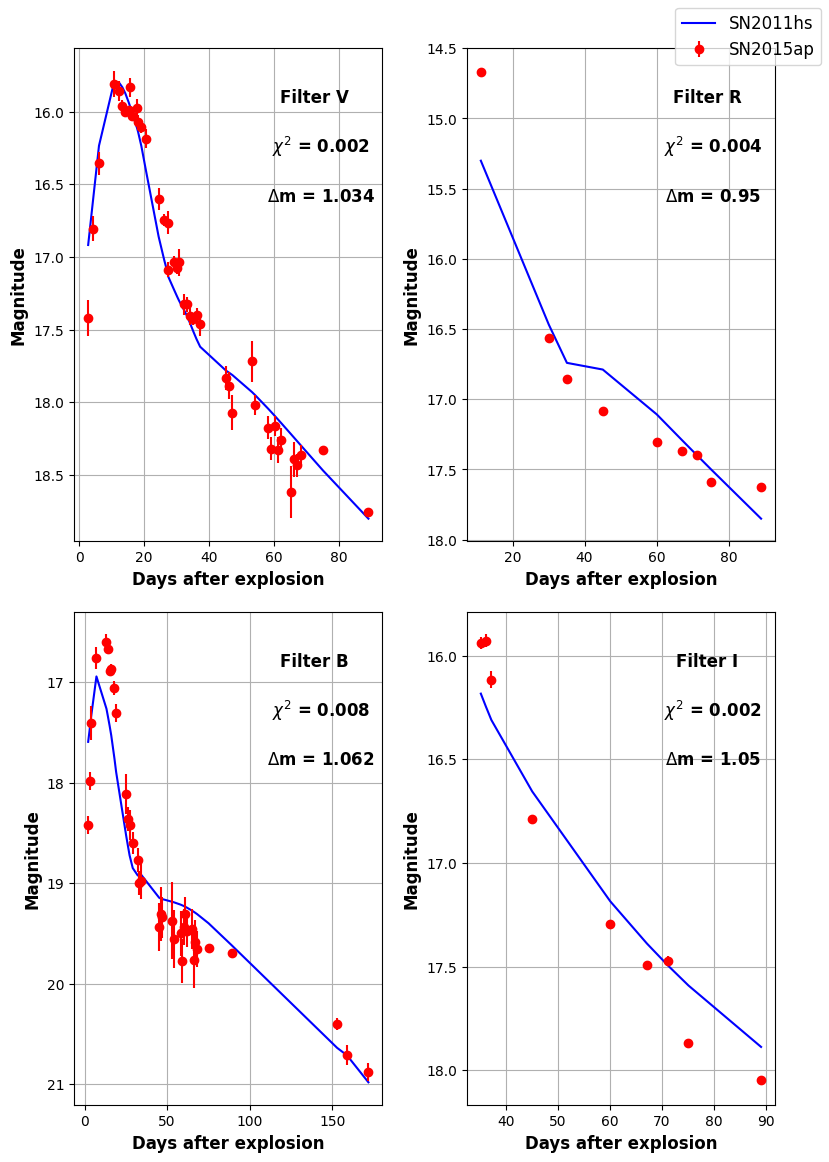

In [21]:
'''
Here I directly compare the new supernova
with the best match, plotting and saving the comparison graphs
'''

name1 = final_name
path1 = data_path + 'data_lightcurves' + "\\"

name2 = new_name
path2 = new_path

lc_filters_1, lc_set_1 = read_lightcurves(name1, path1)
lc_filters_2, lc_set_2 = read_lightcurves(name2, path2)

common_filters = set(lc_filters_1) & set(lc_filters_2)

t0_1 = toe(lc_set_1, lc_filters_1)
t0_2 = toe(lc_set_2, lc_filters_2)

lc_set_1 = rescale_time(lc_filters_1, lc_set_1, t0_1)
lc_set_2 = rescale_time(lc_filters_2, lc_set_2, t0_2)

gp_set_1 = gaussian_process(common_filters, lc_set_1, lc_set_2)

num_filters = len(common_filters)
num_rows    = (num_filters + 1) // 2  
fig, axs    = plt.subplots(num_rows, 2, figsize=(8.27, 11.69)) 
fig.tight_layout(pad=3.0)

deltam = np.array([])
chi = np.array([])

for i, filtro in enumerate(common_filters):
    mag1 = gp_set_1['mag_' + filtro]
    emag1 = gp_set_1['emag_' + filtro]
    time1 = gp_set_1['time_' + filtro]
    mag2 = np.array(lc_set_2['mag_' + filtro])
    emag2 = np.array(lc_set_2['emag_' + filtro])
    time2 = lc_set_2['time_' + filtro]
    dm = np.sum(mag1) / np.sum(mag2)
    mag2 = dm * mag2
    chi2_statistic, _ = chisquare(f_obs=mag1, f_exp=mag2)

    deltam = np.append(deltam, dm)
    chi = np.append(chi, chi2_statistic / len(time2))

    row = i // 2  # Determine the row for the subplot
    col = i % 2   # Determine the column for the subplot

    ax = axs[row, col]
    ax.grid()

    if filtro == 'B':
        ax.plot(time1, mag1, color='blue', label=name1)
        ax.errorbar(time2, mag2, emag2, fmt='o', color='red', label=name2)
    else:
        ax.plot(time1, mag1, color='blue')
        ax.errorbar(time2, mag2, emag2, fmt='o', color='red')

    ax.set_xlabel('Days after explosion', fontsize=12, fontweight='bold')
    ax.set_ylabel('Magnitude', fontsize=12, fontweight='bold')
    ax.invert_yaxis()

    ax.text(0.78, 0.9, f'Filter {filtro}', transform=ax.transAxes,
            fontsize=12, fontweight='bold', ha='center', va='center')
    ax.text(0.8, 0.8, f'$\chi^2$ = {round(chi[i], 3)}', transform=ax.transAxes,
            fontsize=12, fontweight='bold', ha='center', va='center')
    ax.text(0.8, 0.7, f'$\Delta$m = {round(deltam[i], 3)}', transform=ax.transAxes,
            fontsize=12, fontweight='bold', ha='center', va='center')

fig.legend(loc='upper right', fontsize=12)

fig_name = new_path + 'Comparison.png'
plt.savefig(fig_name)
plt.show()
plt.close()


# Section 3: building templates

In [ ]:
class build_templates():

  def __init__(self, name, path, bandpass, min_w, max_w, mean_m, mean_q, ref_files, ref_sp_set, ref_t0):

    self.name       = name
    self.path       = path
    self.filterlist = bandpass['filterlist']
    self.centroid   = bandpass['centroid']
    self.fwhm       = bandpass['fwhm']
    self.min_w      = min_w
    self.max_w      = max_w
    self.m          = mean_m
    self.q          = mean_q
    self.ref_files  = ref_files
    self.ref_sp_set = ref_sp_set
    self.ref_t0     = ref_t0

  def read_lightcurves(self):  

    name_file = self.path + self.name + ".dat"
    lc_set    = defaultdict(int)
    time_array  = ([])
    mag_array   = ([])
    emag_array  = ([])
    band_list   = []

    with open(name_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            time = float(parts[0])
            mag  = float(parts[1])
            emag = float(parts[2])
            band = parts[3]

            time_array = np.append(time_array, time)
            mag_array  = np.append(mag_array, mag)
            emag_array = np.append(emag_array, emag)
            band_list.append(band)

    lc_filters = [band_list[0]]
    for i in range(len(band_list)-1):
      if band_list[i] != band_list[i+1]:
        lc_filters.append(band_list[i+1])

    for filtro in lc_filters:
      lc_set['time_%s'%filtro]  = [time_array[index]   for index, val in enumerate(band_list) if val == filtro]
      lc_set['mag_%s' %filtro]  = [mag_array[index]    for index, val in enumerate(band_list) if val == filtro]
      lc_set['emag_%s'%filtro]  = [emag_array[index]   for index, val in enumerate(band_list) if val == filtro]


    return (lc_filters, lc_set)


  def t0(self, lc_filters, lc_set): 

    t0, t1, dt = ([]), ([]), ([])

    for filtro in lc_filters:
      time = np.array(lc_set['time_' + filtro])
      t1   = np.append(t1, time[0])
      dt   = np.append(dt, avg_distance(time[0:10]))
      t0   = np.append(t0, t1-dt)

    min_value = np.min(t0)

    return min_value


  def scale_lcs(self, lc_filters, lc_set, t0): 

    new_set            = {}
    for filtro in lc_filters:
      time                      = np.array(lc_set['time_' + filtro])
      mag                       = np.array(lc_set['mag_' + filtro])
      emag                      = np.array(lc_set['emag_' + filtro])
      scale_time                = time - t0
      scale_time, mag, emag     = order_sorting(scale_time, mag, emag)
      new_set['time_%s'%filtro] = scale_time
      new_set['mag_%s'%filtro]  = mag
      new_set['emag_%s'%filtro] = emag

    return lc_filters, new_set


  def gaussian_process_on_lcs(self, lc_filters, new_set): #modificato!

    gp_set = defaultdict(int)

    for filtro in lc_filters:
      x           = np.array(new_set['time_' + filtro])
      y           = np.array(new_set['mag_'  + filtro])
      yerr        = np.array(new_set['emag_' + filtro])


      x           = np.append(x, 200)
      y           = np.append(y, 25)
      yerr        = np.append(yerr, 0.1*25)

      amplitude   = np.mean(y)

      lengthscale0 = np.mean(x)
      lengthscale1 = np.min(sampling_step(x))
      lengthscale2 = np.max(sampling_step(x))

      k0           = amplitude * Matern32Kernel(lengthscale0)
      k1           = amplitude * Matern32Kernel(lengthscale1)
      k2           = amplitude * Matern32Kernel(lengthscale2)

      kernel       = k1 + k2 + k0

      gp          = george.GP(kernel)
      star        = gp.compute(x, yerr)

      p0          = gp.get_parameter_vector()
      results     = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
      gp.set_parameter_vector(results.x)

      t           = np.linspace(0, 200, len(y))
      mu, cov     = gp.predict(y, t)
      std         = np.sqrt(cov.diagonal())

      eff_wav = [self.centroid[i] for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
      wav_c   = np.repeat(eff_wav[0], len(mu))

      new_mu  = (mu - self.q) / self.m
      flux    = light_vel_A * 10**(- 0.4* (new_mu + 48.6)) / (eff_wav[0] **2)

      gp_set['flux_%s'%filtro]  = flux
      gp_set['wave_%s'%filtro]  = wav_c
      gp_set['time_%s'%filtro]  = t
      gp_set['mag_%s'%filtro]   = mu
      gp_set['std_%s'%filtro]   = std

    return gp_set


  def injection(self, lc_filters, gp_set):  

    total_flux  = ([])
    total_wave  = ([])
    total_time  = ([])

    for filtro in lc_filters:
      total_flux = np.append(total_flux, gp_set['flux_'+filtro])
      total_wave = np.append(total_wave, gp_set['wave_'+filtro])
      total_time = np.append(total_time, gp_set['time_'+filtro])

    return total_flux, total_wave, total_time


  def scale_real_spectra(self):     

    scaled_files = self.ref_files - self.ref_t0
    scaled_set   = defaultdict(int)

    for epoch in self.ref_files:
      flux = self.ref_sp_set['flux_' + str(epoch)]
      wave = self.ref_sp_set['wave_' + str(epoch)]

      scaled_set['flux_%s'%str(epoch-self.ref_t0)] = flux
      scaled_set['wave_%s'%str(epoch-self.ref_t0)] = wave

    return scaled_files, scaled_set

  def under_files(self, scaled_files):

    under_files = ([])
    for epoch in scaled_files:
      if epoch <= 200:
        under_files = np.append(under_files, epoch)

    return under_files


  def cut_real_spectra(self, total_flux, scaled_set, under_files):

    cut_epoch = 1
    go        = True

    limit_points = 5000

    while go:
        cut_files = under_files[0::cut_epoch]
        all_points = []

        for epoch in cut_files:
            obs_flux = scaled_set['flux_' + str(epoch)]
            all_points = np.append(all_points, obs_flux)

        if len(all_points)+len(total_flux) > limit_points:
            medium_points = len(all_points) / len(cut_files)
            medium_desire = limit_points / len(cut_files)
            cut_points = math.ceil(medium_points / medium_desire)
            total_points = all_points[0::cut_points]

            if len(total_points)+len(total_flux) > limit_points:
                cut_epoch += 1
            else:
                go = False
        else:
            go = False

    return cut_epoch, cut_points


  def total_spectra(self, total_flux, total_time, total_wave, under_files, scaled_set, cut_epoch, cut_points):

    add_obs_epoch = ([])

    for epoch in under_files[0::cut_epoch]:
      obs_wave      = scaled_set['wave_'+str(epoch)]
      obs_flux      = scaled_set['flux_'+str(epoch)]
      obs_time      = np.repeat(epoch, len(obs_flux))
      total_flux    = np.append(total_flux, obs_flux[0::cut_points])
      total_wave    = np.append(total_wave, obs_wave[0::cut_points])
      total_time    = np.append(total_time, obs_time[0::cut_points])
      add_obs_epoch = np.append(add_obs_epoch, epoch)

    return total_flux, total_wave, total_time, add_obs_epoch

  def get_total_time(self, add_obs_epoch):

    min_time                = int(0)
    max_time                = int(200)

    index       = 100 - len(add_obs_epoch)
    step        = (max_time - min_time) / (index-1)
    time_series = np.arange(min_time, max_time + step, step=step, dtype=int)

    new_time_series = sorted(time_series.tolist() + add_obs_epoch.tolist())

    return new_time_series


  def bi_gaussian_process(self, total_flux, total_wave, total_time):

    x    = total_time
    y    = total_flux
    z    = total_wave
    yerr = y * 0.1

    y_scale     = np.mean(y)
    z_scale     = 3000
    x_scale_1   = np.min(sampling_step(x))
    x_scale_2   = np.max(sampling_step(x))

    k1          = y_scale * Matern32Kernel([x_scale_1,z_scale], ndim = 2)
    k2          = y_scale * Matern32Kernel([x_scale_2,z_scale], ndim = 2)

    kernel      = k1 + k2

    gp          = george.GP(kernel)
    p0          = gp.get_parameter_vector()

    d2d         = np.matrix([x, z])
    star        = gp.compute(d2d.T, yerr)

    results     = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
    gp.set_parameter_vector(results.x)

    return gp



  def prediction(self, gp, new_time_series, total_flux, total_wave, total_time):

    pred_set    = defaultdict(int)

    x                                     = np.array(total_time)
    y                                     = np.array(total_flux)
    z                                     = np.array(total_wave)

    for epoch in new_time_series:
      x_pred     = epoch
      z_pred     = np.linspace(min_w, max_w, len(y))
      tot_pred   = np.vstack([np.full_like(z_pred, x_pred), z_pred]).T
      pred_mean, pred_var = gp.predict(y, tot_pred, return_var=True)

      pred_set['flux_%s'%str(epoch)]  = pred_mean
      pred_set['eflux_%s' %str(epoch)]  = np.sqrt(pred_var)
      pred_set['wave_%s' %str(epoch)]  = z_pred

    return (pred_set, new_time_series)


  def scale_factor(self):

    ref_ofm_15    = ([])
    ref_ofm_30    = ([])
    ref_ofm_60    = ([])
    ref_ofm_100   = ([])
    ref_ofm_130   = ([])
    ref_ofm_160   = ([])
    ref_ofm_200   = ([])


    for epoch in self.ref_files:

      ref_time   = epoch - self.ref_t0
      ref_flux   = np.array(self.ref_sp_set['flux_'+str(epoch)])
      mean_order = magnitude_order(np.mean(ref_flux))

      if ref_time <=15:  ref_ofm_15   = np.append(ref_ofm_15, mean_order)
      if ref_time <=30:  ref_ofm_30   = np.append(ref_ofm_30, mean_order)
      if ref_time <=60:  ref_ofm_60   = np.append(ref_ofm_60, mean_order)
      if ref_time <=100: ref_ofm_100  = np.append(ref_ofm_100, mean_order)
      if ref_time <=130: ref_ofm_130  = np.append(ref_ofm_130, mean_order)
      if ref_time <=160: ref_ofm_160  = np.append(ref_ofm_160, mean_order)
      if ref_time >160:  ref_ofm_200  = np.append(ref_ofm_200, mean_order)

    ref_ofm_15  = new_mean(ref_ofm_15)
    ref_ofm_30  = new_mean(ref_ofm_30)
    ref_ofm_60  = new_mean(ref_ofm_60)
    ref_ofm_100 = new_mean(ref_ofm_100)
    ref_ofm_130 = new_mean(ref_ofm_130)
    ref_ofm_160 = new_mean(ref_ofm_160)
    ref_ofm_200 = new_mean(ref_ofm_200)


    offset = ([ref_ofm_15, ref_ofm_30, ref_ofm_60, ref_ofm_100, ref_ofm_130, ref_ofm_160, ref_ofm_200])
    media  = int(np.mean(offset[offset!=0]))

    for i in range(len(offset)):
      if offset[i] == 0:
        offset[i] = media

    return offset

  def add_offset(self, offset, pred_set, new_time_series, t0):

    final_time_series = new_time_series + t0
    final_set         = defaultdict(int)

    for epoch in new_time_series:
      syn_flux = np.array(pred_set['flux_'  + str(epoch)])
      syn_err  = np.array(pred_set['eflux_' + str(epoch)])
      syn_ofm  = abs(magnitude_order(np.mean(syn_flux)))

      new_flux = syn_flux * 10**syn_ofm
      new_err  = syn_err  * 10**syn_ofm

      if epoch <=15:   new_mean = new_flux * 10**offset[0]; new_std = new_err * 10**offset[0]
      if epoch <=30:   new_mean = new_flux * 10**offset[1]; new_std = new_err * 10**offset[1]
      if epoch <=60:   new_mean = new_flux * 10**offset[2]; new_std = new_err * 10**offset[2]
      if epoch <=100:  new_mean = new_flux * 10**offset[3]; new_std = new_err * 10**offset[3]
      if epoch <=130:  new_mean = new_flux * 10**offset[4]; new_std = new_err * 10**offset[4]
      if epoch <=160:  new_mean = new_flux * 10**offset[5]; new_std = new_err * 10**offset[5]
      if epoch >160:   new_mean = new_flux * 10**offset[6]; new_std = new_err * 10**offset[6]

      new_epoch = epoch + t0

      pred_wav = pred_set['wave_' + str(epoch)]

      final_set['flux_%s'  %str(new_epoch)]   = new_mean
      final_set['eflux_%s' %str(new_epoch)]   = new_std
      final_set['wave_%s'  %str(new_epoch)]   = pred_wav

    return final_set, final_time_series


  def build_and_save(self, new_name, new_path, save = False):

    lc_filters, lc_set                 = self.read_lightcurves()
    t0                                 = self.t0(lc_filters, lc_set)
    lc_filters, new_set                = self.scale_lcs(lc_filters, lc_set, t0)
    gp_set                             = self.gaussian_process_on_lcs(lc_filters, new_set)
    total_flux, total_wave, total_time = self.injection(lc_filters, gp_set)
    scaled_files, scaled_set           = self.scale_real_spectra()
    under_files                        = self.under_files(scaled_files)
    cut_epoch, cut_points              = self.cut_real_spectra(total_flux, scaled_set, under_files)
    total_flux, total_wave, total_time, add_obs_epoch = self.total_spectra(total_flux, total_time, total_wave, under_files,
                                                                           scaled_set, cut_epoch, cut_points)
    new_time_series                    = self.get_total_time(add_obs_epoch)
    gp                                 = self.bi_gaussian_process(total_flux, total_wave, total_time) ; print('Check GP')
    pred_set, new_time_series          = self.prediction(gp, new_time_series, total_flux, total_wave, total_time) ; print('Check Prediction')
    offset                             = self.scale_factor()
    final_set, final_time_series       = self.add_offset(offset, pred_set, new_time_series, t0)

    if save == True:

      new_folder = new_path + 'Templates' + "\\"

      if not os.path.exists(new_folder):
        os.makedirs(new_folder)

      #Create the data files

      for epoch in final_time_series:
        flux = final_set['flux_'+str(epoch)]
        wave = final_set['wave_'+str(epoch)]
        std  = final_set['eflux_'+str(epoch)]
        filename  = new_name + "_" + str(epoch)
        matrice   = np.column_stack((wave, flux, std))
        file_path = os.path.join(new_folder, f"{filename}.dat")
        np.savetxt(file_path, matrice, delimiter='\t', fmt='%s')

      #Create the plots

      i = 0
      plt.figure(figsize=(8.27, 11.69))
      plt.grid()
      cut_series = final_time_series[0::5]
      for epoch in cut_series:
        flux = final_set['flux_' + str(epoch)]
        wave = final_set['wave_' + str(epoch)]
        plt.plot(wave, np.log(flux) - 10 * i, color='blue')
        plt.xlabel('Wavelength [$\AA$]', fontsize=12, fontweight='bold')
        plt.ylabel('log(flux) - offset', fontsize=12, fontweight='bold')
        if epoch == cut_series[0] or epoch == cut_series[len(cut_series) // 2] or epoch == cut_series[-1]:
          plt.text(wave[-1] + 50, np.log(flux[-1]) - 10 * i, f'+ {int(epoch-t0)} days', fontsize=10, fontweight='bold', va='center')
        i += 1

      fig_name = new_path + 'templates.png'
      plt.savefig(fig_name)
      plt.close()


    return (final_set, final_time_series)

In [ ]:
'''
Here I define the parameters of the reference supernova.
'''

ref_name                                       = final_name
ref_path                                       = data_path + 'data_lightcurves' + "\\"
ref_files, ref_sp, ref_filters, ref_lcs, _ , _ =  data_extraction(ref_name, data_path, acc, tresh, bandpass).total_exploration()
ref_t0                                         = toe(ref_lcs, ref_filters)

In [ ]:
'''

Here I build templates for the case-of-study Supernova
if save == True I'll save out templates + final graph
if save == False I don't save anything just use the arrays

'''
execute = False

if execute:
  save = True

  app_data_path = app_path + new_name + "\\"
  my_class      = build_templates(new_name, app_data_path, bandpass, min_w, max_w, mean_m, mean_q, ref_files, ref_sp, ref_t0)
  final_set, final_time_series = my_class.build_and_save(new_name, new_path, save=save)

In [ ]:
'''
If I want to analyze every
step of the process

my_class                           = build_templates(new_name, app_data_path, bandpass, min_w, max_w, mean_m, mean_q, ref_files, ref_sp, ref_t0)
lc_filters, lc_set                 = my_class.read_lightcurves()
t0                                 = my_class.t0(lc_filters, lc_set)
lc_filters, new_set                = my_class.scale_lcs(lc_filters, lc_set, t0)
gp_set                             = my_class.gaussian_process_on_lcs(lc_filters, new_set)
total_flux, total_wave, total_time = my_class.injection(lc_filters, gp_set)
scaled_files, scaled_set           = my_class.scale_real_spectra()
under_files                        = my_class.under_files(scaled_files)
cut_epoch, cut_points              = my_class.cut_real_spectra(total_flux, scaled_set, under_files)
total_flux, total_wave, total_time, add_obs_epoch = my_class.total_spectra(total_flux, total_time, total_wave, under_files,
                                                                        scaled_set, cut_epoch, cut_points)
new_time_series                    = my_class.get_total_time(add_obs_epoch)
gp                                 = my_class.bi_gaussian_process(total_flux, total_wave, total_time) ; print('Check GP')
pred_set, new_time_series          = my_class.prediction(gp, new_time_series, total_flux, total_wave, total_time) ; print('Check Prediction')
offset                             = my_class.scale_factor(pred_set, new_time_series)
final_set, final_time_series       = my_class.add_offset(offset, pred_set, new_time_series, t0)

'''

# Section 4: parameters reconstruction

In [ ]:
class parameters():

  def __init__(self, name, files, sp_set, sp_filters, lc_filters, lc_set, bandpass, nsteps):

    self.name         = name
    self.files        = files
    self.sp_set       = sp_set
    self.lc_filters   = lc_filters
    self.lc_set       = lc_set
    self.sp_filters   = sp_filters
    self.filterlist   = bandpass['filterlist']
    self.centroid     = bandpass['centroid']
    self.fwhm         = bandpass['fwhm']
    self.corr_mag     = bandpass['corr_mag']
    self.nsteps       = nsteps

  def gaussian_process_on_lcs(self, t0): 

    gp_set = defaultdict(int)

    for filtro in self.lc_filters:
      x           = np.array(self.lc_set['time_' + filtro])
      y           = np.array(self.lc_set['mag_'  + filtro])
      yerr        = np.array(self.lc_set['emag_' + filtro])

      x           = np.append(x, t0+200)
      y           = np.append(y, 25)
      yerr        = np.append(yerr, 0.1*25)

      amplitude   = np.mean(y)

      lengthscale0 = np.mean(x)
      lengthscale1 = np.min(sampling_step(x))
      lengthscale2 = np.max(sampling_step(x))

      k0           = amplitude * Matern32Kernel(lengthscale0)
      k1           = amplitude * Matern32Kernel(lengthscale1)
      k2           = amplitude * Matern32Kernel(lengthscale2)

      kernel       = k1 + k2 + k0

      gp          = george.GP(kernel)
      star        = gp.compute(x, yerr)

      p0          = gp.get_parameter_vector()
      results     = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
      gp.set_parameter_vector(results.x)

      t           = np.linspace(t0, t0+20, len(y))
      mu, cov     = gp.predict(y, t)
      std         = np.sqrt(cov.diagonal())

      gp_set['time_%s'%filtro]   = t
      gp_set['mag_%s'%filtro]    = mu
      gp_set['emag_%s'%filtro]   = std

    return gp_set

  def time_of_explosion(self):

    t0, t1, dt = ([]), ([]), ([])

    for filtro in self.lc_filters:
      time = np.array(self.lc_set['time_' + filtro])
      t1   = np.append(t1, time[0])
      dt   = np.append(dt, avg_distance(time[0:10]))
      t0   = np.append(t0, t1-dt)

    min_value = np.min(t0)
    std_value = dt[t0==np.min(t0)]

    return min_value, std_value

  def extinction(self, gp_set):

    if len(set(['B']).intersection(self.lc_filters)) == True: f1 = 'B'
    else: f1 = 'g'
    if len(set(['V']).intersection(self.lc_filters)) == True: f2 = 'V'
    else: f2 = 'i'

    timeV    = np.array(gp_set['time_' + f2])
    magB     = np.array(gp_set['mag_' + f1])
    magV     = np.array(gp_set['mag_' + f2])
    emagB    = np.array(gp_set['emag_' + f1])
    emagV    = np.array(gp_set['emag_' + f2])

    for i in range(len(timeV)):
      if magV[i] == np.min(magV):
        tmax     = timeV[i]
        err_tmax = avg_distance(timeV)

    indexB = np.argmin(magB)
    indexV = np.argmin(magV)

    B  = magB[indexB]
    eB = emagB[indexB]
    V  = magV[indexV]
    eV = emagV[indexV]

    E       = (B-V)
    sigma_E = np.sqrt(eB**2 + eV**2)

    Ax      = 3.1 * E
    sigma_A = 3.1 * sigma_E

    return Ax, sigma_A, tmax, err_tmax


  def velocity(self, save_files, doppler, unc_doppler):

    c             = light_vel_km
    velocity_set  = defaultdict(int)
    velocity_lis  = ([])
    unc_velocity  = ([])

    for i in range(len(save_files)):

      vel     = doppler[i]     * c
      unc     = unc_doppler[i] * c

      velocity_set['vel_%s'    %str(save_files[i])] = vel
      velocity_set['unc_vel_%s'%str(save_files[i])] = unc

      velocity_lis = np.append(velocity_lis, vel)
      unc_velocity = np.append(unc_velocity, unc)

    return velocity_set, velocity_lis, unc_velocity


  def med_velocity(self, velocity_lis, unc_velocity):

    mean_velocity = np.mean(velocity_lis)
    mean_error    = np.sqrt(np.sum(np.square(unc_velocity))) / len(velocity_lis)

    return mean_velocity, mean_error

  def distance(self, redshift, unc_redshift):

    c             = light_vel_km
    H             = Hubble_70
    distance      = redshift * c / H
    unc_dist      = unc_redshift * c / H

    return distance, unc_dist


  def sed_fitting(self, distance, redshift):

    bb_set   = defaultdict(int)
    bound_t  = np.array([1000, 30000])
    bound_r  = np.array([1000, 20000]) * R_sun_mpc
    bound_z  = np.array([0, 1])
    bounds   = ([bound_t[0], bound_r[0], bound_z[0]], [bound_t[1], bound_r[1], bound_z[1]])
    mh_files = ([])

    for epoch in self.files:

      wave     = np.array(self.sp_set['wave_'   + str(epoch)])
      flux     = np.array(self.sp_set['flux_'   + str(epoch)])

      sp_bands = self.sp_filters['filt_' + str(epoch)]
      sed      = np.array([])
      wave_c   = np.array([])

      for filtro in sp_bands:

        min_wave = [self.centroid[i]-self.fwhm[i]/2   for i in range(0, len(self.filterlist))  if self.filterlist[i] == filtro]
        max_wave = [self.centroid[i]+self.fwhm[i]/2   for i in range(0, len(self.filterlist))  if self.filterlist[i] == filtro]
        med_wave = [self.centroid[i]                  for i in range(0, len(self.filterlist))  if self.filterlist[i] == filtro]

        mask     = np.logical_and(wave >= min_wave, wave<= max_wave)
        int_flux = trapz( flux[mask] , wave[mask])

        if int_flux > 0:
          sed     = np.append(sed, int_flux)
          wave_c  = np.append(wave_c, med_wave[0])

      if len(sed) >=5:

        wave_c, sed = time_sorting(wave_c, sed)
        wave_c      = wave_c/(1+redshift)

        err         = np.linspace(np.std(sed), np.std(sed), len(sed))

        fit_func = partial(blackbody, distance=distance)
        pars, cov = curve_fit(fit_func, wave_c , sed, sigma = err, maxfev=50000, bounds=bounds)

        if np.any(np.isinf(cov)) == False:
          bb_set['temperature_%s'%epoch]   = pars[0]
          bb_set['radius_%s'%epoch]        = pars[1]
          bb_set['zeta_%s'%epoch]          = pars[2]
          bb_set['cov_%s'%epoch]           = cov
          bb_set['wavec_%s'%epoch]         = wave_c
          bb_set['sed_%s'  %epoch]         = sed
          bb_set['err_%s'  %epoch]         = err

          mh_files = np.append(mh_files, epoch)

    MH                                        = hastings(self.nsteps, bounds, model = fit_func)
    mh_set                                    = MH.final_results_sedfitting(mh_files, self.sp_set, bb_set)

    return (mh_set, mh_files)

  def med_sed(self, mh_set, mh_files):

    tem, rad, zet       = ([]), ([]), ([])
    err_t, err_r, err_z = ([]), ([]), ([])
    for epoch in mh_files:
      tem = np.append(tem, mh_set['temperature_' + str(epoch)])
      rad = np.append(rad, mh_set['radius_' + str(epoch)])
      zet = np.append(zet, mh_set['zeta_' + str(epoch)])

      err_t = np.append(err_t, mh_set['err_t_' + str(epoch)])
      err_r = np.append(err_r, mh_set['err_r_' + str(epoch)])
      err_z = np.append(err_z, mh_set['err_z_' + str(epoch)])

    temperature   = np.mean(tem)
    radius        = np.mean(rad)
    zeta          = np.mean(zet)
    mean_error_t  = np.sqrt(np.sum(np.square(err_t))) / len(tem)
    mean_error_r  = np.sqrt(np.sum(np.square(err_r))) / len(rad)
    mean_error_z  = np.sqrt(np.sum(np.square(err_z))) / len(zet)

    return temperature, radius, zeta, mean_error_t, mean_error_r, mean_error_z


  def prog_radius(self, mh_set, t0, mh_files):

    radius  = ([])
    time    = ([])

    for epoch in mh_files:
      if epoch - int(t0) < 60:

        radius = np.append(radius, mh_set['radius_' + str(epoch)])
        time   = np.append(time, epoch-int(t0))

    radius      = radius * 3.08567758128e+19  / R_sun_km
    mask        = (time >= 0) & (time <= 20)
    mask_time   = time[mask]
    mask_radius = radius[mask]

    x      = mask_time
    y      = mask_radius
    yerr   = y*0.1

    amplitude   = np.mean(y)

    lengthscale0 = np.mean(x)
    lengthscale1 = np.min(sampling_step(x))
    lengthscale2 = np.max(sampling_step(x))

    k0           = amplitude * Matern32Kernel(lengthscale0)
    k1           = amplitude * Matern32Kernel(lengthscale1)
    k2           = amplitude * Matern32Kernel(lengthscale2)

    kernel       = k1 + k2 + k0

    gp          = george.GP(kernel)
    star        = gp.compute(x, yerr)

    p0          = gp.get_parameter_vector()
    results     = op.minimize(nll, p0, args = (y, gp, star), jac=grad_nll, method="L-BFGS-B")
    gp.set_parameter_vector(results.x)

    t           = np.linspace(0, np.max(x), len(x))
    mu, cov     = gp.predict(y, t)
    std         = np.sqrt(cov.diagonal())
    R0     = mu[0]
    err_R0 = std[0]

    if int(time[0]) == 0 and radius[0] < mu[0]:
      R0 = radius[0]

    return R0, err_R0


  def luminosity(self, tmax, distance, inc_d, gp_set):

    peak_flux  = ([])
    peak_wave  = ([])
    peak_error_flux = ([])

    for filtro in lc_filters:
      #if filtro != 'UVW2' and filtro !='UVM2' and filtro !='UVW1':
        t            = lc_set['time_' + filtro]
        close_time   = min(t, key = lambda x: abs(x-tmax))
        if close_time - tmax < 10:
          mag       = gp_set['mag_' + filtro]
          time      = gp_set['time_' + filtro]
          emag      = gp_set['emag_' + filtro]

          closest   = min(time, key = lambda x: abs(x-tmax))
          peak_mag  = [mag[i]           for i in range(len(mag))              if time[i] == closest]
          peak_emag = [emag[i]          for i in range(len(mag))              if time[i] == closest]
          wavv      = [self.centroid[i] for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]

          single_flux = light_vel_A * 10**(- 0.4* (peak_mag[0] + 48.6)) / wavv[0] **2
          peak_flux = np.append(peak_flux, single_flux)

          peak_wave = np.append(peak_wave, wavv[0])

          single_flux_unc = abs(-0.4 * math.log(10) * single_flux)*peak_emag[0]
          peak_error_flux = np.append(peak_error_flux, single_flux_unc)

    peak_wave, peak_flux, peak_error_flux = order_sorting(peak_wave, peak_flux, peak_error_flux)

    int_flux        = trapz(peak_flux, peak_wave)                                  #erg/s/cm^2
    delta_int_flux = 0.0

    for i in range(len(peak_flux)):
        derivative_flux = peak_wave[i]
        derivative_wave = peak_flux[i]
        delta_int_flux += (derivative_flux * peak_error_flux[i])**2 + (derivative_wave * peak_wave[i])**2

    delta_int_flux = np.sqrt(delta_int_flux)

    dist_cm  = distance * 3.0856775813e+24
    inc_d_cm = inc_d    * 3.0856775813e+24

    Lum  = 4*np.pi * dist_cm**2 * int_flux                                   #erg/s

    der_dist = 8*np.pi*dist_cm*int_flux
    der_flux = 4*np.pi*dist_cm**2

    eLum = np.sqrt( (der_dist*inc_d_cm)**2 + (der_flux*delta_int_flux))

    return Lum, eLum


  def energy(self, tmax, Lum, error_Lum):

    tmax_s     = tmax * 86400
    energy     = Lum * tmax_s       #erg
    err_energy = error_Lum * tmax_s
    
    return energy, err_energy


  def ejecta_mass(self, tmax, save_files,velocity_set, energy, error_energy):

    epoch   = min(save_files, key = lambda x: abs(x-tmax))
    vel     = velocity_set['vel_' + str(epoch)]         #km/s
    err_v   = velocity_set['unc_vel_%s'%str(epoch)]     #km/s
    vel_cm  = vel   * 100000                            #cm/s
    err_v   = err_v * 100000

    Mej     = 6/5 * energy / vel_cm**2

    der_eg  = 6/5 / vel_cm**2
    der_vel = 12/5 * energy/vel_cm**3

    err_Mej = np.sqrt( (der_eg*error_energy)**2 + (der_vel*err_v)**2)

    return Mej/M_sun_g, err_Mej/M_sun_g

  def prog_mass(self, Mej):

    M_NS = 1.2 #solar mass
    M_BH = 10  #solar mass

    Mpr  = (Mej + M_NS, Mej + M_BH)

    return Mpr

  def luminosity_vs_time(self, t0, distance, decay_time):

    dist_cm    = distance * 3.0856775813e+24
    lum_array  = ([])
    time_array = ([])

    for t1 in decay_time:
      flux = ([])
      wave = ([])
      for filtro in self.lc_filters:
        mag       = self.lc_set['mag_' + filtro]
        time      = self.lc_set['time_' + filtro]
        closest   = min(time, key = lambda x: abs(x-t1))
        if abs(t1-closest) < 5:
          magg      = [mag[i]           for i in range(len(mag))              if time[i] == closest]
          wavv      = [self.centroid[i] for i in range(len(self.filterlist))  if self.filterlist[i] == filtro]
          flux      = np.append(flux, light_vel_A * 10**(- 0.4* (magg[0] + 48.6)) / wavv[0] **2)
          wave      = np.append(wave, wavv[0])
        else:
          continue

      if len(wave) < 1: continue

      wave, flux = time_sorting(wave, flux)
      int_flux   = trapz(flux, wave)                             #erg/s/cm^2
      Lum        = 4*np.pi * dist_cm**2 * int_flux               #erg/s

      lum_array  = np.append(lum_array, Lum)
      time_array = np.append(time_array, t1-t0)

    return lum_array, time_array

  def nichel_mass(self, distance, t0):

    t1 = t0+120
    t2 = t0+300
    lum_array       = np.zeros(1)
    time_array      = ([])
    i               = 0

    redux_step = 5

    while len(set(lum_array)) - list(lum_array).count(0) < 4:

      t1                    = t0 + 120 - redux_step*i
      decay_time            = np.arange(t1, t2, dtype=int, step = 5)
      lum_array, time_array = self.luminosity_vs_time(t0, distance, decay_time)
      i+=1

      if t1-t0<0: break

    gamma_1 = 1.32e-6 #s-1  Ni decay rate
    gamma_2 = 1.02e-7 #s-1  Co decay rate

    t       = time_array * 86400
    x       = 3.90e+10 * np.exp(-gamma_1*t) + 6.78e+9 * (np.exp(-gamma_2*t) - np.exp(-gamma_1*t))
    y       = lum_array
    linear_model  = np.polyfit(x,y,1)
    m       = linear_model[0]
    q       = linear_model[1]
    Mni     = m/M_sun_g

    residuals               = y - (m * x + q)
    residual_sum_of_squares = np.sum(residuals**2)
    std_error_m             = np.sqrt(residual_sum_of_squares / (len(x) - 2)) / np.sqrt(np.sum((x - np.mean(x))**2))
    err_Mni                 = std_error_m/M_sun_g

    return Mni, err_Mni

  def run_parameters(self):

    t0, err_t0                                         = self.time_of_explosion()
    gp_set                                             = self.gaussian_process_on_lcs(t0)
    Ax, err_Ax, tmax, err_tmax                         = self.extinction(gp_set)
    save_files, doppler, err_dop, redshift, err_red, classe = line_fitting(self.files, self.sp_set, t0).velocity_and_redshift()
    velocity_set, velocity_lis, err_velocity           = self.velocity(save_files, doppler, err_dop)
    mean_vel, mean_err_vel                             = self.med_velocity(velocity_lis, err_velocity)
    dist, err_d                                        = self.distance(redshift, err_red)
    mh_set, mh_files                                   = self.sed_fitting(dist, redshift)
    tem, rad, zet, mean_err_t, mean_err_r, mean_err_z  = self.med_sed(mh_set, mh_files)
    R, err_R                                           = self.prog_radius(mh_set, t0, mh_files)
    Lum, err_L                                         = self.luminosity(tmax, dist, err_d, gp_set)
    energy, err_E                                      = self.energy(tmax, Lum, err_L)
    Mej, err_Mej                                       = self.ejecta_mass(tmax, save_files, velocity_set, energy, err_E)
    Mni, err_Mni                                       = self.nichel_mass(dist, t0)
    Mpr                                                = self.prog_mass(Mej)

    results = {
        'classe'        : classe,
        'extinction'    : (round(Ax,2) , round(err_Ax, 2)),
        't0'            : (round(t0, 2), round(err_t0, 2)),
        'tmax'          : (round(tmax, 2), round(err_tmax, 2)),
        'vel'           : (int(mean_vel), int(mean_err_vel)),
        'red'           : (round(redshift, 4), round(err_red, 4)),
        'dist'          : (round(dist, 2), round(err_d, 2)),
        'temp'          : (int(tem), int(mean_err_t)),
        'rad'           : (int(rad/R_sun_mpc), int(mean_err_r/R_sun_mpc)),
        'zeta'          : (round(zet, 3), round(mean_err_z, 3)),
        'Lum'           : (round(Lum/10**(41),3), round(err_L/10**(41), 3)),
        'E'             : (round(energy/10**(52), 3), round(err_E/10**(52), 3)),
        'Mej'           : (round(Mej, 3), round(err_Mej, 3)),
        'Mni'           : (round(Mni, 5), round(err_Mni, 5)),
        'Mpr'           : (Mpr, round(err_Mej, 3)),
        'prad'          : (int(R), int(err_R))

    }

    return (results)

In [ ]:
class line_fitting():

  def __init__(self, files, temp_set, t0):

    self.files    = files
    self.temp_set = temp_set
    self.t0       = t0

  def starting_epoch(self):

    YES = False
    i   = 0
    while YES == False:

      epoch = self.files[i]
      wave  = np.array(self.temp_set['wave_'  + str(epoch)])
      flux  = np.array(self.temp_set['flux_'  + str(epoch)])
      plt.figure(figsize=(10,7))
      for line, value in lines.items():
        if value < np.max(wave) and value > np.min(wave):
          plt.plot(wave, flux, '.', color='grey')
          plt.axvline(value, 0, 1,  label=line)
          plt.legend()
      plt.show()
      print('Can you see at least one P-Cygni and one emission line?')
      answer = input().lower()
      if answer == 'yes':
        YES = True
      elif answer == 'no':
        YES = False
        i+=1
      else:
        print("Please enter only yes or no")

    return epoch

  def find_lines(self, epoch):

    wave  = np.array(self.temp_set['wave_'  + str(epoch)])
    flux  = np.array(self.temp_set['flux_'  + str(epoch)])

    for line, value in lines.items():
      if value < np.max(wave) and value > np.min(wave):
        plt.plot(wave, flux, '-')
        plt.axvline(value, 0, 1, label=line)
        plt.legend()
        plt.show()
    print('Select the P-Cygni and the emission lines')
    answer        = input().split(', ')
    p_cygni_line  = answer[0]
    emission_line = answer[1]

    return p_cygni_line, emission_line

  def p_cygni_interval(self, epoch, p_cygni_line):

    wave  = np.array(self.temp_set['wave_'  + str(epoch)])
    flux  = np.array(self.temp_set['flux_'  + str(epoch)])

    red, blu = 50, 250  #this are just hypotetical values

    stop = False

    while stop == False:

      for line, value in lines.items():
        if line == p_cygni_line:
          blue_limit        = value - blu
          red_limit         = value + red
          mask              = np.logical_and(wave >= blue_limit, wave <= red_limit)
          in_wave, in_flux  = wave[mask], flux[mask]

          plt.plot(in_wave, in_flux)
          plt.axvline(value, 0, 1)
          plt.show()
          print('Please insert values to enlarge or reduce the interval')
          print('The first value will add on the left, while the second on the right')
          print('If the interval is okay, just write 0, 0')
          answer     = input()
          values     = answer.split(', ')
          blue_value = int(values[0])
          red_value  = int(values[1])

          red += red_value
          blu += blue_value
          if red_value == blue_value == 0.0:
            stop = True
          else:
            stop = False

    return blu, red

  def emission_interval(self, epoch, emission_line):

    wave  = np.array(self.temp_set['wave_'  + str(epoch)])
    flux  = np.array(self.temp_set['flux_'  + str(epoch)])

    red_e, blu_e = 50, 250  #this are just hypotetical values to start with

    stop = False

    while stop == False:

      for line, value in lines.items():
        if line == emission_line:
          blue_limit        = value - blu_e
          red_limit         = value + red_e
          mask              = np.logical_and(wave >= blue_limit, wave <= red_limit)
          in_wave, in_flux  = wave[mask], flux[mask]

          plt.plot(in_wave, in_flux)
          plt.axvline(value, 0, 1)
          plt.show()
          print('Please insert values to enlarge or reduce the interval')
          print('The first value will add on the left, while the second on the right')
          print('If the interval is okay, just write 0, 0')
          answer     = input()
          values     = answer.split(', ')
          blue_value = int(values[0])
          red_value  = int(values[1])

          red_e += red_value
          blu_e += blue_value
          if red_value == blue_value == 0.0:
            stop = True
          else:
            stop = False

    return blu_e, red_e


  def p_cygni_fitter(self, p_cygni_line, blu, red):

    save_files  = []
    doppler     = ([])
    err_dop     = ([])
    stop        = 0

    for epoch in self.files:
      wave  = np.array(self.temp_set['wave_'  + str(epoch)])
      flux  = np.array(self.temp_set['flux_'  + str(epoch)])

      for line, value in lines.items():
        if line == p_cygni_line:
          blue_limit = value - blu
          red_limit  = value + red
          mask    = np.logical_and(wave >= blue_limit, wave <= red_limit)
          in_wave = wave[mask]
          in_flux = flux[mask]
          if len(in_flux) > 10:
            my_fitting  = np.polyfit(in_wave, in_flux, 4, full=True)
            SSE         = my_fitting[1][0]
            SST         = np.sum((in_flux - in_flux.mean())**2)
            R2          =  1 - SSE/SST
            if R2 > 0.9:
              warnings.filterwarnings("ignore")
              pars        = np.poly1d(np.polyfit(in_wave, in_flux, 8))
              maxi        = in_wave[np.argmax(pars(in_wave))]
              mini        = in_wave[np.argmin(pars(in_wave))]
              if maxi > mini:
                if abs(maxi-np.max(in_wave)) != 0:

                  obs             = (maxi + mini) / 2
                  shift_doppler   = abs(obs-value)  / value
                  doppler         = np.append(doppler, shift_doppler)

                  err_w           = avg_distance(in_wave)
                  err_obs         = 1/np.sqrt(2) * err_w
                  err_dop         = np.append(err_dop, err_obs / value)


                  save_files.append(epoch)
                  stop  = 0

                else:
                  stop = 1
                  break

      if stop == 1:
        break

    plt.plot(save_files - self.t0, doppler)
    return (save_files, doppler, err_dop)


  def emission_fitter(self, epoch, emission_line, blu_e, red_e):

    redshift   = ([])
    err_red    = ([])
    wave       = np.array(self.temp_set['wave_'  + str(epoch)])
    flux       = np.array(self.temp_set['flux_'  + str(epoch)])

    for line, value in lines.items():
      if line == emission_line:
        blue_limit = value - blu_e
        red_limit  = value + red_e
        mask    = np.logical_and(wave >= blue_limit, wave <= red_limit)
        in_wave = wave[mask]
        in_flux = flux[mask]

        if len(in_flux) > 10:
          my_fitting  = np.polyfit(in_wave, in_flux, 4, full=True)
          SSE         = my_fitting[1][0]
          SST         = np.sum((in_flux - in_flux.mean())**2)
          R2          =  1 - SSE/SST
          if R2 > 0.9:
            warnings.filterwarnings("ignore")
            pars        = np.poly1d(np.polyfit(in_wave, in_flux, 8))
            maxi        = in_wave[np.argmax(pars(in_wave))]
            mini        = in_wave[np.argmin(pars(in_wave))]
            if maxi > mini:
                if abs(maxi-np.max(in_wave)) != 0:

                  obs         = maxi
                  shift_cosmo = (obs-value) / value
                  redshift    = np.append(redshift, shift_cosmo)

                  err_obs       = avg_distance(in_wave)
                  err_red       = np.append(err_red, err_obs/value)

    return redshift, err_red


  def classification(self, p_cygni_line):

    Ib = ['He Ia','He Ib', 'He Ic', 'He Id', 'He Ie' ]
    II = ['Ha', 'Hb', 'Hg', 'Hd']

    classe = []

    if p_cygni_line in II:
      classe = 'II'
    elif p_cygni_line in Ib:
      classe = 'Ib'
    else:
      classe = 'Ic'

    return classe


  def velocity_and_redshift(self):

    epoch                          = self.starting_epoch()
    p_cygni_line, emission_line    = self.find_lines(epoch)
    blu, red                       = self.p_cygni_interval(epoch, p_cygni_line)
    blu_e, red_e                   = self.emission_interval(epoch, emission_line)
    save_files, doppler, err_dop   = self.p_cygni_fitter(p_cygni_line, blu, red)
    redshift, err_red              = self.emission_fitter(epoch, emission_line, blu_e, red_e)
    classe                         = self.classification(p_cygni_line)

    return save_files, doppler, err_dop, redshift, err_red, classe


In [ ]:
class hastings:

  def __init__(self, nsteps, bounds, model):
    self.nsteps     = nsteps
    self.bounds     = bounds
    self.model      = model

  def get_model_predictions(self, theta, x):
    return self.model(x, theta[0], theta[1], theta[2])

  def lnlikelihood(self, theta, x, y, err):
    model_preds = self.get_model_predictions(theta, x)
    lnl         = -np.sum((y - model_preds) ** 2 / (2 * err ** 2))
    return lnl

  def lnprior(self, theta):
    a, b, c = theta
    a0, a1 = self.bounds[0][0], self.bounds[1][0]
    b0, b1 = self.bounds[0][1], self.bounds[1][1]
    c0, c1 = self.bounds[0][2], self.bounds[1][2]
    if a0 <= a <= a1 and b0 <= b <= b1 and c0 <= c <= c1:
      lnp = np.log(1/(a1-a0)) + np.log(1/(b1-b0)) + np.log(1/(c1-c0))
    else:
      return -np.inf
    return lnp

  def lnposterior(self, theta, x, y, err):
    lnp = self.lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = self.lnlikelihood(theta, x, y, err)
    lnpost = lnl + lnp
    return lnpost

  def hastings_ratio(self, theta_1, theta_0, x, y, err):
    lnpost1 = self.lnposterior(theta_1, x, y, err)
    lnpost0 = self.lnposterior(theta_0, x, y, err)

    expost1 = np.exp(lnpost1)
    expost0 = np.exp(lnpost0)

    if expost1 != 0 and expost0 != 0:
      h_ratio = expost1 / expost0
      return h_ratio
    else:
      return 0

  def propose_jump(self, theta, cov):

    if np.shape(theta) == np.shape(cov):
        cov = np.diag(np.array(cov)**2)
    proposed_position = np.random.multivariate_normal(theta, cov)

    return proposed_position

  def mh_mcmc(self, theta0, x, y, err, cov):

    positions         = np.zeros((self.nsteps+1, len(theta0)))
    lnpost_at_pos     = -np.inf*np.ones(self.nsteps+1)
    acceptance_ratio  = np.zeros_like(lnpost_at_pos)
    accepted          = 0

    positions[0]      = theta0
    lnpost_at_pos[0]  = self.lnposterior(theta0, x, y, err)

    for step_num in np.arange(1, self.nsteps+1):
        proposal  = self.propose_jump(positions[step_num-1], cov)
        H         = self.hastings_ratio(proposal, positions[step_num-1], x, y, err)
        R         = np.random.uniform()

        if H > R:
            accepted += 1
            positions[step_num]       = proposal
            lnpost_at_pos[step_num]   = self.lnposterior(proposal, x, y, err)
            acceptance_ratio[step_num]= float(accepted)/step_num
        else:
            positions[step_num]       = positions[step_num-1]
            lnpost_at_pos[step_num]   = lnpost_at_pos[step_num-1]
            acceptance_ratio[step_num]= float(accepted)/step_num

    return (positions, lnpost_at_pos, acceptance_ratio)

  def final_results_sedfitting(self, files, sp_set, bb_set):

    mh_set = defaultdict(int)
    ex     = []
    for epoch in files:

      T0   = np.array(bb_set['temperature_' + str(epoch)])
      R0   = np.array(bb_set['radius_'      + str(epoch)])
      Z0   = np.array(bb_set['zeta_'        + str(epoch)])
      cov  = np.array(bb_set['cov_'         + str(epoch)])
      x    = np.array(bb_set['wavec_'       + str(epoch)])
      y    = np.array(bb_set['sed_'         + str(epoch)])
      err  = np.array(bb_set['err_'         + str(epoch)])
      ex.append(epoch)

      theta0         = (T0, R0, Z0)
      pos, lnpost, _ = self.mh_mcmc(theta0, x, y, err, cov)
      for i in range(len(pos)):
        if lnpost[i] == np.max(lnpost):
          pars = pos[i]

          final_t = pars[0] * np.sqrt(pars[2])
          final_r = pars[1]
          final_z = pars[2]
          err_t   = (np.sqrt(final_z) * final_t * 0.1) + 1/2*final_t* np.sqrt(final_z) * 0.1
          err_r   = final_r * 0.1
          err_z   = final_z * 0.1

          mh_set['temperature_' + str(epoch)]  = final_t
          mh_set['radius_' + str(epoch)]       = final_r
          mh_set['zeta_' + str(epoch)]         = final_z
          mh_set['err_t_' + str(epoch)]        = err_t
          mh_set['err_r_' + str(epoch)]        = err_r
          mh_set['err_z_' + str(epoch)]        = err_z

    return mh_set

In [ ]:
'''
Now I apply the parameter reconstruction on my case-of-study SN
'''

execute = True

if execute:



  lc_filters, lc_set          = read_lightcurves(new_name, new_path)
  files, temp_set, sp_filters = templates_extraction(new_name, new_path, acc, tresh, bandpass).use_templates()
  par                         = parameters(new_name, files, temp_set, sp_filters, lc_filters, lc_set, bandpass, nsteps)
  #results                     = par.run_parameters()
  #print(results)

In [ ]:
t0, err_t0                                         = par.time_of_explosion()
gp_set                                             = par.gaussian_process_on_lcs(t0)
Ax, err_Ax, tmax, err_tmax                         = par.extinction(gp_set)
save_files, doppler, err_dop, redshift, err_red, classe = line_fitting(files, temp_set, t0).velocity_and_redshift()
velocity_set, velocity_lis, err_velocity           = par.velocity(save_files, doppler, err_dop)
mean_vel, mean_err_vel                             = par.med_velocity(velocity_lis, err_velocity)
dist, err_d                                        = par.distance(redshift, err_red)
mh_set, mh_files                                   = par.sed_fitting(dist, redshift)
tem, rad, zet, mean_err_t, mean_err_r, mean_err_z  = par.med_sed(mh_set, mh_files)
R, err_R                                           = par.prog_radius(mh_set, t0, mh_files)
Lum, err_L                                         = par.luminosity(tmax, dist, err_d, gp_set)
energy, err_E                                      = par.energy(tmax, Lum, err_L)
Mej, err_Mej                                       = par.ejecta_mass(tmax, save_files, velocity_set, energy, err_E)
Mni, err_Mni                                       = par.nichel_mass(dist, t0)
Mpr                                                = par.prog_mass(Mej)

print('class:', '\t', classe)
print('Ax:', '\t', round(Ax,2), '+/-', round(err_Ax, 2))
print('t0:', '\t', round(t0, 2), '+/-', round(err_t0, 2))
print('tmax:', '\t', round(tmax, 2), '+/-',  round(err_tmax, 2))
print('vel:', '\t', int(mean_vel), '+/-', int(mean_err_vel))
print('z:', '\t', round(redshift[0], 4), '+/-', round(err_red[0], 4))
print('dist:', '\t',  round(dist[0], 2), '+/-', round(err_d[0], 2))
print('tem:', '\t', int(tem), '+/-', int(mean_err_t))
print('rad:', '\t', int(rad/R_sun_mpc), '+/-', int(mean_err_r/R_sun_mpc))
print('zeta:', '\t', round(zet, 3), '+/-', round(mean_err_z, 3))
print('L:', '\t', round(Lum[0]/10**(41),3), '+/-', round(err_L[0]/10**(41), 3))
print('E:', '\t', round(energy[0]/10**(52), 3), '+/-', round(err_E[0]/10**(52), 3))
print('Mej:', '\t', round(Mej[0], 3), '+/-', round(err_Mej[0], 3))
print('Mni:', '\t', round(Mni, 5), '+/-', round(err_Mni, 5))
print('Mpr:', '\t', '(', Mpr[0], ',', Mpr[1], ')', '+/-', round(err_Mej[0], 3))
print('R:', '\t', int(R), '+/-', int(err_R))

# Section 5: comparison between synthetic spectra and real spectra


## Extraction

In [ ]:
'''
get_time is a function used to estrapolate epoch informations
from a file name. I explored different conventions that I found
on WISeREP, but there could be more.

name  = string input, the file name containing the dates to convert
cut   = the position of the first number of the date
t     = time
t.mjd = float output, the time in MJD units.
'''


def get_time(name):

  for i in range(len(name)):

    # This should work for file names in the form of: 'AAA_YYYY-MM-DD-hh-mm-ss_'
    if name[i-11] == '_' and name[i-6] == '-' and name[i-3] == '-' and name[i] == '_':
      cut = (i-10)
      date = name[ cut : (cut + 10) ]
      times = name[ (cut + 10 + 1) : (cut + 10 + 1 + 8) ]
      times = times.replace("-", ":")
      t_total = date + ' ' + times
      t = TT(t_total, format='iso', scale='utc')
      final_time = t.mjd

    # This should work for file names in the form of: 'AAA_timein.jd_'
    if name[i-8] == '_' and name[i-7] == '2' and name[i] == '.':
      cut = i-7
      name = name[cut:-1]
      cutter = [i for i in range(len(name)) if name[i]== '_']
      timejd = float(name[0: cutter[0]])
      final_time = timejd - 2400000.5

    # This should work for file names in the form of: 'AAA_YYYY-MM-DD.minutesJD'
    if name[i-11] == '_' and name[i-6] == '-' and name[i-3] == '-' and name[i]=='.':
      date_cut    = i-10
      minutes_cut = i+1
      date        = name[date_cut : (date_cut + 10)]
      minutes     = float(name[minutes_cut : minutes_cut + 2])
      t           = TT(date, format='iso', scale='utc')
      timejd      = t.jd + minutes/100
      final_time  = timejd - 2400000.5

  #I know it's brutal but...this works only for SN2009bw
  if name[0:6] == '2009bw':
    YY = name[7:11]
    MM = name[11:13]
    DD = name[13:15]
    t_total = YY + '-' + MM + '-' + DD
    t = TT(t_total, format='iso', scale='utc')
    final_time = t.mjd


  return final_time

In [ ]:
new_files = False

if new_files:

#Here I extract and correct new files

  sp_set        = defaultdict(int)
  spectra_path  = app_path + 'SN2015ap/Real spectra/'
  files         = os.listdir(spectra_path)
  epoch         = np.array([])
  new_epoch     = np.array([])
  final_epoch   = np.array([])


  for single_file in files:
    epoch = np.append(epoch, get_time(single_file))
  epoch, files  = time_sorting(epoch, files)
  for i in range(len(epoch)):
    if epoch[i] == epoch[i-1]:
      new_epoch = np.append(new_epoch, epoch[i] + 0.01*i)
    else:
      new_epoch = np.append(new_epoch, epoch[i])


  for k in range(len(files)):

    sp_set['wave_%s'%new_epoch[k]] = []
    sp_set['flux_%s'%new_epoch[k]] = []
    sp_set['eflux_%s'%new_epoch[k]] = []

    path_ = app_path + 'SN2015ap/Real spectra/' + files[k]
    data  = ascii.read(path_)
    wave  = data[0][:]
    flux  = data[1][:]
    if len(data.colnames) > 2: eflux = data[2][:]
    else: eflux = flux*0.1

    new_f = np.array([])
    new_w = np.array([])
    new_e = np.array([])

    for i in range(len(flux)):
      if flux[i] > 0 and np.isnan(flux[i]) == False:
        if magnitude_order(flux[i]) in range(-8, 100):
          flux[i]   = flux[i]   * 10e-15
          eflux[i]  = eflux[i]  * 10e-15

        new_f = np.append(new_f, flux[i])
        new_w = np.append(new_w, wave[i])
        new_e = np.append(new_e, eflux[i])

    flux  = np.array([])
    wave  = np.array([])
    eflux = np.array([])

    index0  = round(len(new_f)/2) - 50
    cent    = new_f[index0:index0 + 100]
    med     = np.mean(cent)

    for j in range(len(new_f)):
      if magnitude_order(new_f[j]) in range(magnitude_order(med)-2, magnitude_order(med)+2):
        wave  = np.append(wave, new_w[j])
        flux  = np.append(flux, new_f[j])
        eflux = np.append(eflux, new_e[j])

    for d in range(len(eflux)):
      if eflux[d] == 0.0 or math.isnan(eflux[d]):
        eflux[d] = flux[d] * 0.1
      if eflux[d] < 0:
        eflux[d] = abs(eflux[d])

    logflux = np.log(flux)
    logerr  = eflux * (1/eflux) ** 0.5

    avg     = np.average(logflux, weights= logerr)
    std     = np.std(logflux)


    for u in range(len(logflux)):
      if logflux[u] >= avg - 4*std and logflux[u] <= avg + 4*std:
        sp_set['wave_%s' %str(new_epoch[k])].append(wave[u])
        sp_set['flux_%s' %str(new_epoch[k])].append(flux[u])
        sp_set['eflux_%s'%str(new_epoch[k])].append(eflux[u])
        final_epoch = np.append(final_epoch, new_epoch[k])

  final_epoch = np.unique(final_epoch)

#And here I save each new file with MY

  spectra_path = app_path + 'SN2015ap/Real_spectra/'

  if not os.path.exists(spectra_path):
      os.makedirs(spectra_path)

  for epoch in final_epoch:
      flux = sp_set['flux_' + str(epoch)]
      wave = sp_set['wave_' + str(epoch)]
      eflux = sp_set['eflux_' + str(epoch)]
      name = 'SN2015ap_' + str(epoch)
      data = np.column_stack((wave, flux, eflux))
      file_path = os.path.join(spectra_path, name + '.dat')
      np.savetxt(file_path, data, fmt='%.8e', delimiter='\t', header='wave\tflux\teflux', comments='')


else:


  sp_set        = defaultdict(int)
  spectra_path  = spectra_path = app_path + 'SN2015ap/Real_spectra/'
  all_files     = os.listdir(spectra_path)
  all_epochs    = ([])


  for single_file in all_files:
    file_name    = single_file.split('_')[1]
    epoch        = file_name.rsplit('.', 1)[0]

    all_epochs  = np.append(all_epochs, float(epoch))
    data        = ascii.read(spectra_path + single_file)
    sp_set['wave_%s'%str(epoch)]  = data[0][:]
    sp_set['flux_%s'%str(epoch)]  = data[1][:]
    sp_set['eflux_%s'%str(epoch)] = data[2][:]


real_epoch, real_set = all_epochs, sp_set
real_epoch = np.sort(real_epoch)

In [ ]:
def read_templates(name):

  temp_set      = defaultdict(int)
  spectra_path = app_path + 'SN2015ap/Templates/'
  all_files     = os.listdir(spectra_path)
  all_epochs    = ([])

  for single_file in all_files:
    file_name    = single_file.split('_')[1]
    epoch        = float(file_name.rsplit('.', 1)[0])
    all_epochs   = np.append(all_epochs, float(epoch))
    data         = ascii.read(spectra_path + single_file)

    temp_set['wave_%s'%str(epoch)]  = np.array(data[0][:])
    temp_set['flux_%s'%str(epoch)]  = np.array(data[1][:])
    temp_set['eflux_%s'%str(epoch)] = np.array(data[2][:])

  return all_epochs, temp_set

temp_epoch, temp_set = read_templates('SN2015ap')


## Confronto

In [ ]:
'''
What is comparable in time?

epoch_1, epoch_2 =  real_epoch[1] , temp_epoch[2]   #120
epoch_1, epoch_2 =  real_epoch[2] , temp_epoch[8]   #42
epoch_1, epoch_2 =  real_epoch[6] , temp_epoch[14]  #2
epoch_1, epoch_2 =  real_epoch[9] , temp_epoch[19]  # 220
epoch_1, epoch_2 =  real_epoch[10] , temp_epoch[25]  # 220

'''

In [ ]:
temp_epoch[25]-t0

In [ ]:
real_epoch[9]

In [ ]:
epoch_1, epoch_2 =  real_epoch[10] , temp_epoch[25]
temp_flux, temp_wave = temp_set['flux_' + str(epoch_2)], temp_set['wave_' + str(epoch_2)]
real_flux, real_wave = real_set['flux_' + str(epoch_1)], real_set['wave_' + str(epoch_1)]

temp_flux = temp_flux / np.mean(temp_flux)
real_flux = real_flux / np.mean(real_flux)
plt.plot(temp_wave, temp_flux, color='red')
plt.plot(real_wave, real_flux, color='blue')

In [ ]:
epoch_1, epoch_2 =  real_epoch[9] , temp_epoch[19]

temp_flux, temp_wave = temp_set['flux_' + str(epoch_2)], temp_set['wave_' + str(epoch_2)]
real_flux, real_wave = real_set['flux_' + str(epoch_1)], real_set['wave_' + str(epoch_1)]
plt.plot(temp_wave, temp_flux/220, color='red')
plt.plot(real_wave, real_flux, color='blue')

In [ ]:
epocae = ([real_epoch[1], temp_epoch[2]], [real_epoch[10], temp_epoch[25]])

fig, axs = plt.subplots(2, 1, figsize=(8.27, 11.69))
fig.tight_layout(pad=3.0)

for idx, epochs in enumerate(epocae):
    epoch_1, epoch_2 = epochs[0], epochs[1]

    temp_flux, temp_wave = temp_set['flux_' + str(epoch_2)], temp_set['wave_' + str(epoch_2)]
    real_flux, real_wave = real_set['flux_' + str(epoch_1)], real_set['wave_' + str(epoch_1)]
    temp_flux = temp_flux / np.mean(temp_flux)
    real_flux = real_flux / np.mean(real_flux)

    if idx == 0:
        axs[0].plot(real_wave, real_flux, label='Real spectrum', color='blue')
        axs[0].plot(temp_wave, temp_flux, label='Synthetic spectrum', color='red')
        axs[0].grid()
        axs[0].set_xlabel('Wavelength [$\AA$]', fontsize=12, fontweight='bold')
        axs[0].set_ylabel('Normalized flux density', fontsize=12, fontweight='bold')
        axs[0].text(0.95, 0.75, f'+{int(epoch_1-t0)} days after the explosion', ha='right', va='center', transform=axs[0].transAxes,
                    fontsize=12, fontweight='bold', color='black')

    else:
        axs[1].plot(real_wave, real_flux, color='blue')
        axs[1].plot(temp_wave, temp_flux, color='red')
        axs[1].grid()
        axs[1].set_xlabel('Wavelength [$\AA$]', fontsize=12, fontweight='bold')
        axs[1].set_ylabel('Normalized flux density', fontsize=12, fontweight='bold')
        axs[1].text(0.95, 0.75, f'+{int(epoch_1-t0)} days after the explosion', ha='right', va='center', transform=axs[1].transAxes,
                    fontsize=12, fontweight='bold', color='black')

fig.legend(loc='upper right', fontsize=12)
plt.show()


In [ ]:
'''
Qui per trovare il rescale corretto
'''

epoch_1, epoch_2 = real_epoch[8], temp_epoch[9]

temp_flux, temp_wave = temp_set['flux_' + str(epoch_2)], temp_set['wave_' + str(epoch_2)]
real_flux, real_wave = real_set['flux_' + str(epoch_1)], real_set['wave_' + str(epoch_1)]

for i in range(28,40):
  plt.plot(real_wave, real_flux, label='Real spectrum', color='orange')
  plt.plot(temp_wave, temp_flux / i, label='Synthetic spectrum', color='blue')
  plt.title(str(i))
  plt.show()

# ACHTUNG

Al momento ci sono dei problemini da risolvere, che potrebbero aumentare 

1. a partire da redshift (e poi di conseguenza, dist e tutti quanti), queste variabili sono salvate come array e non come float
2. sono sicuro al 100% che hai delle librerie inutili
3. sono sicuro al 100% che hai delle funzioni inutili
4. controlla se all'interno di alcune operazioni definisci cose inutili 
5. magari togliamo gli italianismi estremi
6. La velocità deve smettere di studiare le righe quando torna a crescere 

In [2]:
lc_filters, lc_set          = read_lightcurves(new_name, new_path)
files, temp_set, sp_filters = templates_extraction(new_name, new_path, acc, tresh, bandpass).use_templates()
par                         = parameters(new_name, files, temp_set, sp_filters, lc_filters, lc_set, bandpass, nsteps)
t0, err_t0                  = par.time_of_explosion()

NameError: name 'read_lightcurves' is not defined

In [ ]:

YES = False
i   = 0
while YES == False:

    epoch = files[i]
    wave  = np.array(temp_set['wave_'  + str(epoch)])
    flux  = np.array(temp_set['flux_'  + str(epoch)])
    plt.figure(figsize=(10,7))
    for line, value in lines.items():
        if value < np.max(wave) and value > np.min(wave):
            plt.plot(wave, flux, '.', color='black')
            plt.axvline(value, 0, 1,  label=line)
            plt.legend()
    plt.show()
    print('Can you see at least one P-Cygni and one emission line?')
    answer = input().lower()
    if answer == 'yes':
        YES = True
    elif answer == 'no':
        YES = False
        i+=1
    else:
        print("Please enter only yes or no")

In [ ]:
class line_fitting():

  def __init__(self, files, temp_set, t0):

    self.files    = files
    self.temp_set = temp_set
    self.t0       = t0

  def starting_epoch(self):

    YES = False
    i   = 0
    while YES == False:

      epoch = self.files[i]
      wave  = np.array(self.temp_set['wave_'  + str(epoch)])
      flux  = np.array(self.temp_set['flux_'  + str(epoch)])
      plt.figure(figsize=(10,7))
      for line, value in lines.items():
        if value < np.max(wave) and value > np.min(wave):
          plt.plot(wave, flux, '.', color='black')
          plt.axvline(value, 0, 1,  label=line)
          plt.legend()
      plt.show()
      print('Can you see at least one P-Cygni and one emission line?')
      answer = input().lower()
      if answer == 'yes':
        YES = True
      elif answer == 'no':
        YES = False
        i+=1
      else:
        print("Please enter only yes or no")

    return epoch

  def find_lines(self, epoch):

    wave  = np.array(self.temp_set['wave_'  + str(epoch)])
    flux  = np.array(self.temp_set['flux_'  + str(epoch)])

    for line, value in lines.items():
      if value < np.max(wave) and value > np.min(wave):
        plt.plot(wave, flux, '-')
        plt.axvline(value, 0, 1, label=line)
        plt.legend()
        plt.show()
    print('Select the P-Cygni and the emission lines')
    answer        = input().split(', ')
    p_cygni_line  = answer[0]
    emission_line = answer[1]

    return p_cygni_line, emission_line

  def p_cygni_interval(self, epoch, p_cygni_line):

    wave  = np.array(self.temp_set['wave_'  + str(epoch)])
    flux  = np.array(self.temp_set['flux_'  + str(epoch)])

    red, blu = 50, 250  #this are just hypotetical values

    stop = False

    while stop == False:

      for line, value in lines.items():
        if line == p_cygni_line:
          blue_limit        = value - blu
          red_limit         = value + red
          mask              = np.logical_and(wave >= blue_limit, wave <= red_limit)
          in_wave, in_flux  = wave[mask], flux[mask]

          plt.plot(in_wave, in_flux)
          plt.axvline(value, 0, 1)
          plt.show()
          print('Please insert values to enlarge or reduce the interval')
          print('The first value will add on the left, while the second on the right')
          print('If the interval is okay, just write 0, 0')
          answer     = input()
          values     = answer.split(', ')
          blue_value = int(values[0])
          red_value  = int(values[1])

          red += red_value
          blu += blue_value
          if red_value == blue_value == 0.0:
            stop = True
          else:
            stop = False

    return blu, red

  def emission_interval(self, epoch, emission_line):

    wave  = np.array(self.temp_set['wave_'  + str(epoch)])
    flux  = np.array(self.temp_set['flux_'  + str(epoch)])

    red_e, blu_e = 50, 250  #this are just hypotetical values to start with

    stop = False

    while stop == False:

      for line, value in lines.items():
        if line == emission_line:
          blue_limit        = value - blu_e
          red_limit         = value + red_e
          mask              = np.logical_and(wave >= blue_limit, wave <= red_limit)
          in_wave, in_flux  = wave[mask], flux[mask]

          plt.plot(in_wave, in_flux)
          plt.axvline(value, 0, 1)
          plt.show()
          print('Please insert values to enlarge or reduce the interval')
          print('The first value will add on the left, while the second on the right')
          print('If the interval is okay, just write 0, 0')
          answer     = input()
          values     = answer.split(', ')
          blue_value = int(values[0])
          red_value  = int(values[1])

          red_e += red_value
          blu_e += blue_value
          if red_value == blue_value == 0.0:
            stop = True
          else:
            stop = False

    return blu_e, red_e


  def p_cygni_fitter(self, p_cygni_line, blu, red):

    save_files  = []
    doppler     = ([])
    err_dop     = ([])
    stop        = 0

    for epoch in self.files:
      wave  = np.array(self.temp_set['wave_'  + str(epoch)])
      flux  = np.array(self.temp_set['flux_'  + str(epoch)])

      for line, value in lines.items():
        if line == p_cygni_line:
          blue_limit = value - blu
          red_limit  = value + red
          mask    = np.logical_and(wave >= blue_limit, wave <= red_limit)
          in_wave = wave[mask]
          in_flux = flux[mask]
          if len(in_flux) > 10:
            my_fitting  = np.polyfit(in_wave, in_flux, 4, full=True)
            SSE         = my_fitting[1][0]
            SST         = np.sum((in_flux - in_flux.mean())**2)
            R2          =  1 - SSE/SST
            if R2 > 0.9:
              warnings.filterwarnings("ignore")
              pars        = np.poly1d(np.polyfit(in_wave, in_flux, 8))
              maxi        = in_wave[np.argmax(pars(in_wave))]
              mini        = in_wave[np.argmin(pars(in_wave))]
              if maxi > mini:
                if abs(maxi-np.max(in_wave)) != 0:

                  obs             = (maxi + mini) / 2
                  shift_doppler   = abs(obs-value)  / value
                  doppler         = np.append(doppler, shift_doppler)

                  err_w           = avg_distance(in_wave)
                  err_obs         = 1/np.sqrt(2) * err_w
                  err_dop         = np.append(err_dop, err_obs / value)


                  save_files.append(epoch)
                  stop  = 0

                else:
                  stop = 1
                  break

      if stop == 1:
        break

    plt.plot(save_files - self.t0, doppler)
    return (save_files, doppler, err_dop)


  def emission_fitter(self, epoch, emission_line, blu_e, red_e):

    redshift   = ([])
    err_red    = ([])
    wave       = np.array(self.temp_set['wave_'  + str(epoch)])
    flux       = np.array(self.temp_set['flux_'  + str(epoch)])

    for line, value in lines.items():
      if line == emission_line:
        blue_limit = value - blu_e
        red_limit  = value + red_e
        mask    = np.logical_and(wave >= blue_limit, wave <= red_limit)
        in_wave = wave[mask]
        in_flux = flux[mask]

        if len(in_flux) > 10:
          my_fitting  = np.polyfit(in_wave, in_flux, 4, full=True)
          SSE         = my_fitting[1][0]
          SST         = np.sum((in_flux - in_flux.mean())**2)
          R2          =  1 - SSE/SST
          if R2 > 0.9:
            warnings.filterwarnings("ignore")
            pars        = np.poly1d(np.polyfit(in_wave, in_flux, 8))
            maxi        = in_wave[np.argmax(pars(in_wave))]
            mini        = in_wave[np.argmin(pars(in_wave))]
            if maxi > mini:
                if abs(maxi-np.max(in_wave)) != 0:

                  obs         = maxi
                  shift_cosmo = (obs-value) / value
                  redshift    = np.append(redshift, shift_cosmo)

                  err_obs       = avg_distance(in_wave)
                  err_red       = np.append(err_red, err_obs/value)

    return redshift, err_red


  def classification(self, p_cygni_line):

    Ib = ['He Ia','He Ib', 'He Ic', 'He Id', 'He Ie' ]
    II = ['Ha', 'Hb', 'Hg', 'Hd']

    classe = []

    if p_cygni_line in II:
      classe = 'II'
    elif p_cygni_line in Ib:
      classe = 'Ib'
    else:
      classe = 'Ic'

    return classe


  def velocity_and_redshift(self):

    epoch                          = self.starting_epoch()
    p_cygni_line, emission_line    = self.find_lines(epoch)
    blu, red                       = self.p_cygni_interval(epoch, p_cygni_line)
    blu_e, red_e                   = self.emission_interval(epoch, emission_line)
    save_files, doppler, err_dop   = self.p_cygni_fitter(p_cygni_line, blu, red)
    redshift, err_red              = self.emission_fitter(epoch, emission_line, blu_e, red_e)
    classe                         = self.classification(p_cygni_line)

    return save_files, doppler, err_dop, redshift, err_red, classe
